# CycleGAN, Image-to-Image Translation

In this notebook, we're going to define and train a CycleGAN to read in an image from a set $X$ and transform it so that it looks as if it belongs in set $Y$. Specifically, we'll look at a set of images of [Yosemite national park](https://en.wikipedia.org/wiki/Yosemite_National_Park) taken either during the summer of winter. The seasons are our two domains!

>The objective will be to train generators that learn to transform an image from domain $X$ into an image that looks like it came from domain $Y$ (and vice versa). 

Some examples of image data in both sets are pictured below.

<img src='notebook_images/XY_season_images.png' width=50% />

### Unpaired Training Data

These images do not come with labels, but CycleGANs give us a way to learn the mapping between one image domain and another using an **unsupervised** approach. A CycleGAN is designed for image-to-image translation and it learns from unpaired training data. This means that in order to train a generator to translate images from domain $X$ to domain $Y$, we do not have to have exact correspondences between individual images in those domains. For example, in [the paper that introduced CycleGANs](https://arxiv.org/abs/1703.10593), the authors are able to translate between images of horses and zebras, even though there are no images of a zebra in exactly the same position as a horse or with exactly the same background, etc. Thus, CycleGANs enable learning a mapping from one domain $X$ to another domain $Y$ without having to find perfectly-matched, training pairs!

<img src='notebook_images/horse2zebra.jpg' width=50% />

### CycleGAN and Notebook Structure

A CycleGAN is made of two types of networks: **discriminators, and generators**. In this example, the discriminators are responsible for classifying images as real or fake (for both $X$ and $Y$ kinds of images). The generators are responsible for generating convincing, fake images for both kinds of images. 

This notebook will detail the steps you should take to define and train such a CycleGAN. 

>1. You'll load in the image data using PyTorch's DataLoader class to efficiently read in images from a specified directory. 
2. Then, you'll be tasked with defining the CycleGAN architecture according to provided specifications. You'll define the discriminator and the generator models.
3. You'll complete the training cycle by calculating the adversarial and cycle consistency losses for the generator and discriminator network and completing a number of training epochs. *It's suggested that you enable GPU usage for training.*
4. Finally, you'll evaluate your model by looking at the loss over time and looking at sample, generated images.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


---

## Load and Visualize the Data

We'll first load in and visualize the training data, importing the necessary libraries to do so.

In [2]:
!unzip '/content/drive/My Drive/DATA ML/summer2winter_yosemite.zip'

Streaming output truncated to the last 5000 lines.
  inflating: summer2winter_yosemite/summer/summer/2012-06-01 16:14:33.jpg  
  inflating: __MACOSX/summer2winter_yosemite/summer/summer/._2012-06-01 16:14:33.jpg  
  inflating: summer2winter_yosemite/summer/summer/2012-06-01 19:37:52.jpg  
  inflating: __MACOSX/summer2winter_yosemite/summer/summer/._2012-06-01 19:37:52.jpg  
  inflating: summer2winter_yosemite/summer/summer/2012-06-03 20:17:16.jpg  
  inflating: __MACOSX/summer2winter_yosemite/summer/summer/._2012-06-03 20:17:16.jpg  
  inflating: summer2winter_yosemite/summer/summer/2012-06-04 13:38:16.jpg  
  inflating: __MACOSX/summer2winter_yosemite/summer/summer/._2012-06-04 13:38:16.jpg  
  inflating: summer2winter_yosemite/summer/summer/2012-06-04 19:59:13.jpg  
  inflating: __MACOSX/summer2winter_yosemite/summer/summer/._2012-06-04 19:59:13.jpg  
  inflating: summer2winter_yosemite/summer/summer/2012-06-05 06:09:05.jpg  
  inflating: __MACOSX/summer2winter_yosemite/summer/summer

In [3]:
# loading in and transforming data
import os
import torch
from torch.utils.data import DataLoader
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

# visualizing data
import matplotlib.pyplot as plt
import numpy as np
import warnings

%matplotlib inline

In [4]:
# helper functions for saving sample data and models

# import data loading libraries
import os
import pdb
import pickle
import argparse

import warnings
warnings.filterwarnings("ignore")

# import torch
import torch


# numpy & scipy imports
import numpy as np
import scipy
import scipy.misc
import imageio


def checkpoint(iteration, G_XtoY, G_YtoX, D_X, D_Y, checkpoint_dir='checkpoints_cyclegan'):
    """Saves the parameters of both generators G_YtoX, G_XtoY and discriminators D_X, D_Y.
        """
    G_XtoY_path = os.path.join(checkpoint_dir, 'G_XtoY.pkl')
    G_YtoX_path = os.path.join(checkpoint_dir, 'G_YtoX.pkl')
    D_X_path = os.path.join(checkpoint_dir, 'D_X.pkl')
    D_Y_path = os.path.join(checkpoint_dir, 'D_Y.pkl')
    torch.save(G_XtoY.state_dict(), G_XtoY_path)
    torch.save(G_YtoX.state_dict(), G_YtoX_path)
    torch.save(D_X.state_dict(), D_X_path)
    torch.save(D_Y.state_dict(), D_Y_path)


def merge_images(sources, targets, batch_size=16):
    """Creates a grid consisting of pairs of columns, where the first column in
        each pair contains images source images and the second column in each pair
        contains images generated by the CycleGAN from the corresponding images in
        the first column.
        """
    _, _, h, w = sources.shape
    row = int(np.sqrt(batch_size))
    merged = np.zeros([3, row*h, row*w*2])
    for idx, (s, t) in enumerate(zip(sources, targets)):
        i = idx // row
        j = idx % row
        merged[:, i*h:(i+1)*h, (j*2)*h:(j*2+1)*h] = s
        merged[:, i*h:(i+1)*h, (j*2+1)*h:(j*2+2)*h] = t
    merged = merged.transpose(1, 2, 0)
    return merged
    

def to_data(x):
    """Converts variable to numpy."""
    if torch.cuda.is_available():
        x = x.cpu()
    x = x.data.numpy()
    x = ((x +1)*255 / (2)).astype(np.uint8) # rescale to 0-255
    return x

def save_samples(iteration, fixed_Y, fixed_X, G_YtoX, G_XtoY, batch_size=16, sample_dir='samples_cyclegan'):
    """Saves samples from both generators X->Y and Y->X.
        """
    # move input data to correct device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    fake_X = G_YtoX(fixed_Y.to(device))
    fake_Y = G_XtoY(fixed_X.to(device))
    
    X, fake_X = to_data(fixed_X), to_data(fake_X)
    Y, fake_Y = to_data(fixed_Y), to_data(fake_Y)
    
    merged = merge_images(X, fake_Y, batch_size)
    path = os.path.join(sample_dir, 'sample-{:06d}-X-Y.png'.format(iteration))
    imageio.imwrite(path, merged)
    #scipy.misc.imsave(path, merged)
    print('Saved {}'.format(path))
    
    merged = merge_images(Y, fake_X, batch_size)
    path = os.path.join(sample_dir, 'sample-{:06d}-Y-X.png'.format(iteration))
    imageio.imwrite(path, merged)
    #scipy.misc.imsave(path, merged)
    print('Saved {}'.format(path))


### DataLoaders

The `get_data_loader` function returns training and test DataLoaders that can load data efficiently and in specified batches. The function has the following parameters:
* `image_type`: `summer` or `winter`,  the names of the directories where the X and Y images are stored
* `image_dir`: name of the main image directory, which holds all training and test images
* `image_size`: resized, square image dimension (all images will be resized to this dim)
* `batch_size`: number of images in one batch of data

The test data is strictly for feeding to our generators, later on, so we can visualize some generated samples on fixed, test data.

You can see that this function is also responsible for making sure our images are of the right, square size (128x128x3) and converted into Tensor image types.

**It's suggested that you use the default values of these parameters.**

Note: If you are trying this code on a different set of data, you may get better results with larger `image_size` and `batch_size` parameters. If you change the `batch_size`, make sure that you create complete batches in the training loop otherwise you may get an error when trying to save sample data. 

In [5]:
def get_data_loader(image_type, image_dir='summer2winter_yosemite', 
                    image_size=128, batch_size=16, num_workers=0):
    """Returns training and test data loaders for a given image type, either 'summer' or 'winter'. 
       These images will be resized to 128x128x3, by default, converted into Tensors, and normalized.
    """
    
    # resize and normalize the images
    transform = transforms.Compose([transforms.Resize(image_size), # resize to 128x128
                                    transforms.ToTensor()])

    # get training and test directories
    image_path = './' + image_dir
    train_path = os.path.join(image_path, image_type)
    test_path = os.path.join(image_path, 'test_{}'.format(image_type))

    # define datasets using ImageFolder
    train_dataset = datasets.ImageFolder(train_path, transform)
    test_dataset = datasets.ImageFolder(test_path, transform)

    # create and return DataLoaders
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_loader, test_loader

In [6]:
# Create train and test dataloaders for images from the two domains X and Y
# image_type = directory names for our data
dataloader_X, test_dataloader_X = get_data_loader(image_type='summer')
dataloader_Y, test_dataloader_Y = get_data_loader(image_type='winter')

## Display some Training Images

Below we provide a function `imshow` that reshape some given images and converts them to NumPy images so that they can be displayed by `plt`. This cell should display a grid that contains a batch of image data from set $X$.

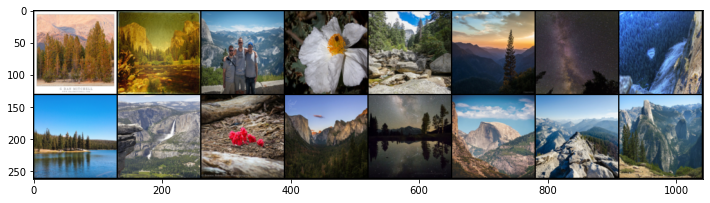

In [7]:
# helper imshow function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    

# get some images from X
dataiter = iter(dataloader_X)
# the "_" is a placeholder for no labels
images, _ = dataiter.next()

# show images
fig = plt.figure(figsize=(12, 8))
imshow(torchvision.utils.make_grid(images))

Next, let's visualize a batch of images from set $Y$.

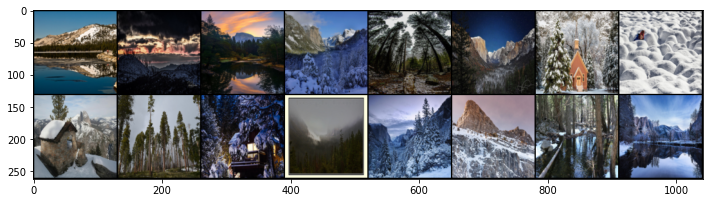

In [8]:
# get some images from Y
dataiter = iter(dataloader_Y)
images, _ = dataiter.next()

# show images
fig = plt.figure(figsize=(12,8))
imshow(torchvision.utils.make_grid(images))

### Pre-processing: scaling from -1 to 1

We need to do a bit of pre-processing; we know that the output of our `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [9]:
# current range
img = images[0]

print('Min: ', img.min())
print('Max: ', img.max())

Min:  tensor(0.)
Max:  tensor(0.9961)


In [10]:
# helper scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-255.'''
    
    # scale from 0-1 to feature_range
    min, max = feature_range
    x = x * (max - min) + min
    return x

In [11]:
# scaled range
scaled_img = scale(img)

print('Scaled min: ', scaled_img.min())
print('Scaled max: ', scaled_img.max())

Scaled min:  tensor(-1.)
Scaled max:  tensor(0.9922)


---
## Define the Model

A CycleGAN is made of two discriminator and two generator networks.

## Discriminators

The discriminators, $D_X$ and $D_Y$, in this CycleGAN are convolutional neural networks that see an image and attempt to classify it as real or fake. In this case, real is indicated by an output close to 1 and fake as close to 0. The discriminators have the following architecture:

<img src='notebook_images/discriminator_layers.png' width=80% />

This network sees a 128x128x3 image, and passes it through 5 convolutional layers that downsample the image by a factor of 2. The first four convolutional layers have a BatchNorm and ReLu activation function applied to their output, and the last acts as a classification layer that outputs one value.

### Convolutional Helper Function

To define the discriminators, you're expected to use the provided `conv` function, which creates a convolutional layer + an optional batch norm layer.

In [12]:
import torch.nn as nn
import torch.nn.functional as F

# helper conv function
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                           kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
    
    layers.append(conv_layer)

    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

### Define the Discriminator Architecture

Your task is to fill in the `__init__` function with the specified 5 layer conv net architecture. Both $D_X$ and $D_Y$ have the same architecture, so we only need to define one class, and later instantiate two discriminators. 
> It's recommended that you use a **kernel size of 4x4** and use that to determine the correct stride and padding size for each layer. [This Stanford resource](http://cs231n.github.io/convolutional-networks/#conv) may also help in determining stride and padding sizes.

* Define your convolutional layers in `__init__`
* Then fill in the forward behavior of the network

The `forward` function defines how an input image moves through the discriminator, and the most important thing is to pass it through your convolutional layers in order, with a **ReLu** activation function applied to all but the last layer.

You should **not** apply a sigmoid activation function to the output, here, and that is because we are planning on using a squared error loss for training. And you can read more about this loss function, later in the notebook.

In [13]:
class Discriminator(nn.Module):
    
    def __init__(self, conv_dim=64):
        super(Discriminator, self).__init__()

        # Define all convolutional layers
        # Should accept an RGB image as input and output a single value

        # Convolutional layers, increasing in depth
        # first layer has *no* batchnorm
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False) # x, y = 64, depth 64
        self.conv2 = conv(conv_dim, conv_dim*2, 4) # (32, 32, 128)
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4) # (16, 16, 256)
        self.conv4 = conv(conv_dim*4, conv_dim*8, 4) # (8, 8, 512)
        
        # Classification layer
        self.conv5 = conv(conv_dim*8, 1, 4, stride=1, batch_norm=False)

    def forward(self, x):
        # relu applied to all conv layers but last
        out = F.relu(self.conv1(x))
        out = F.relu(self.conv2(out))
        out = F.relu(self.conv3(out))
        out = F.relu(self.conv4(out))
        # last, classification layer
        out = self.conv5(out)
        return out

## Generators

The generators, `G_XtoY` and `G_YtoX` (sometimes called F), are made of an **encoder**, a conv net that is responsible for turning an image into a smaller feature representation, and a **decoder**, a *transpose_conv* net that is responsible for turning that representation into an transformed image. These generators, one from XtoY and one from YtoX, have the following architecture:

<img src='notebook_images/cyclegan_generator_ex.png' width=90% />

This network sees a 128x128x3 image, compresses it into a feature representation as it goes through three convolutional layers and reaches a series of residual blocks. It goes through a few (typically 6 or more) of these residual blocks, then it goes through three transpose convolutional layers (sometimes called *de-conv* layers) which upsample the output of the resnet blocks and create a new image!

Note that most of the convolutional and transpose-convolutional layers have BatchNorm and ReLu functions applied to their outputs with the exception of the final transpose convolutional layer, which has a `tanh` activation function applied to the output. Also, the residual blocks are made of convolutional and batch normalization layers, which we'll go over in more detail, next.

---
### Residual Block Class

To define the generators, you're expected to define a `ResidualBlock` class which will help you connect the encoder and decoder portions of the generators. You might be wondering, what exactly is a Resnet block? It may sound familiar from something like ResNet50 for image classification, pictured below.

<img src='notebook_images/resnet_50.png' width=90%/>

ResNet blocks rely on connecting the output of one layer with the input of an earlier layer. The motivation for this structure is as follows: very deep neural networks can be difficult to train. Deeper networks are more likely to have vanishing or exploding gradients and, therefore, have trouble reaching convergence; batch normalization helps with this a bit. However, during training, we often see that deep networks respond with a kind of training degradation. Essentially, the training accuracy stops improving and gets saturated at some point during training. In the worst cases, deep models would see their training accuracy actually worsen over time!

One solution to this problem is to use **Resnet blocks** that allow us to learn so-called *residual functions* as they are applied to layer inputs. You can read more about this proposed architecture in the paper, [Deep Residual Learning for Image Recognition](https://arxiv.org/pdf/1512.03385.pdf) by Kaiming He et. al, and the below image is from that paper.

<img src='notebook_images/resnet_block.png' width=40%/>

### Residual Functions

Usually, when we create a deep learning model, the model (several layers with activations applied) is responsible for learning a mapping, `M`, from an input `x` to an output `y`.
>`M(x) = y` (Equation 1)

Instead of learning a direct mapping from `x` to `y`, we can instead define a **residual function**
> `F(x) = M(x) - x`

This looks at the difference between a mapping applied to x and the original input, x. `F(x)` is, typically, two convolutional layers + normalization layer and a ReLu in between. These convolutional layers should have the same number of inputs as outputs. This mapping can then be written as the following; a function of the residual function and the input x. The addition step creates a kind of loop that connects the input x to the output, y:
>`M(x) = F(x) + x` (Equation 2) or

>`y = F(x) + x` (Equation 3)

#### Optimizing a Residual Function

The idea is that it is easier to optimize this residual function `F(x)` than it is to optimize the original mapping `M(x)`. Consider an example; what if we want `y = x`?

From our first, direct mapping equation, **Equation 1**, we could set `M(x) = x` but it is easier to solve the residual equation `F(x) = 0`, which, when plugged in to **Equation 3**, yields `y = x`.


### Defining the `ResidualBlock` Class

To define the `ResidualBlock` class, we'll define residual functions (a series of layers), apply them to an input x and add them to that same input. This is defined just like any other neural network, with an `__init__` function and the addition step in the `forward` function. 

In our case, you'll want to define the residual block as:
* Two convolutional layers with the same size input and output
* Batch normalization applied to the outputs of the convolutional layers
* A ReLu function on the output of the *first* convolutional layer

Then, in the `forward` function, add the input x to this residual block. Feel free to use the helper `conv` function from above to create this block.

In [14]:
# residual block class
class ResidualBlock(nn.Module):
    """Defines a residual block.
       This adds an input x to a convolutional layer (applied to x) with the same size input and output.
       These blocks allow a model to learn an effective transformation from one domain to another.
    """
    def __init__(self, conv_dim):
        super(ResidualBlock, self).__init__()
        # conv_dim = number of inputs
        
        # define two convolutional layers + batch normalization that will act as our residual function, F(x)
        # layers should have the same shape input as output; I suggest a kernel_size of 3
        
        self.conv_layer1 = conv(in_channels=conv_dim, out_channels=conv_dim, 
                                kernel_size=3, stride=1, padding=1, batch_norm=True)
        
        self.conv_layer2 = conv(in_channels=conv_dim, out_channels=conv_dim, 
                               kernel_size=3, stride=1, padding=1, batch_norm=True)
        
    def forward(self, x):
        # apply a ReLu activation the outputs of the first layer
        # return a summed output, x + resnet_block(x)
        out_1 = F.relu(self.conv_layer1(x))
        out_2 = x + self.conv_layer2(out_1)
        return out_2
    

### Transpose Convolutional Helper Function

To define the generators, you're expected to use the above `conv` function, `ResidualBlock` class, and the below `deconv` helper function, which creates a transpose convolutional layer + an optional batchnorm layer.

In [15]:
# helper deconv function
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a transpose convolutional layer, with optional batch normalization.
    """
    layers = []
    # append transpose conv layer
    layers.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False))
    # optional batch norm layer
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

---
## Define the Generator Architecture

* Complete the `__init__` function with the specified 3 layer **encoder** convolutional net, a series of residual blocks (the number of which is given by `n_res_blocks`), and then a 3 layer **decoder** transpose convolutional net.
* Then complete the `forward` function to define the forward behavior of the generators. Recall that the last layer has a `tanh` activation function.

Both $G_{XtoY}$ and $G_{YtoX}$ have the same architecture, so we only need to define one class, and later instantiate two generators.

In [16]:
class CycleGenerator(nn.Module):
    
    def __init__(self, conv_dim=64, n_res_blocks=6):
        super(CycleGenerator, self).__init__()

        # 1. Define the encoder part of the generator
        
        # initial convolutional layer given, below
        self.conv1 = conv(3, conv_dim, 4)
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)

        # 2. Define the resnet part of the generator
        # Residual blocks
        res_layers = []
        for layer in range(n_res_blocks):
            res_layers.append(ResidualBlock(conv_dim*4))
        # use sequential to create these layers
        self.res_blocks = nn.Sequential(*res_layers)

        # 3. Define the decoder part of the generator
        # two transpose convolutional layers and a third that looks a lot like the initial conv layer
        self.deconv1 = deconv(conv_dim*4, conv_dim*2, 4)
        self.deconv2 = deconv(conv_dim*2, conv_dim, 4)
        # no batch norm on last layer
        self.deconv3 = deconv(conv_dim, 3, 4, batch_norm=False)

    def forward(self, x):
        """Given an image x, returns a transformed image."""
        # define feedforward behavior, applying activations as necessary

        out = F.relu(self.conv1(x))
        out = F.relu(self.conv2(out))
        out = F.relu(self.conv3(out))

        out = self.res_blocks(out)

        out = F.relu(self.deconv1(out))
        out = F.relu(self.deconv2(out))
        # tanh applied to last layer
        out = F.tanh(self.deconv3(out))

        return out

---
## Create the complete network

Using the classes you defined earlier, you can define the discriminators and generators necessary to create a complete CycleGAN. The given parameters should work for training.

First, create two discriminators, one for checking if $X$ sample images are real, and one for checking if $Y$ sample images are real. Then the generators. Instantiate two of them, one for transforming a painting into a realistic photo and one for transforming a photo into  into a painting.

In [17]:
def create_model(g_conv_dim=64, d_conv_dim=64, n_res_blocks=6):
    """Builds the generators and discriminators."""
    
    # Instantiate generators
    G_XtoY = CycleGenerator(conv_dim=g_conv_dim, n_res_blocks=n_res_blocks)
    G_YtoX = CycleGenerator(conv_dim=g_conv_dim, n_res_blocks=n_res_blocks)
    # Instantiate discriminators
    D_X = Discriminator(conv_dim=d_conv_dim)
    D_Y = Discriminator(conv_dim=d_conv_dim)

    # move models to GPU, if available
    if torch.cuda.is_available():
        device = torch.device("cuda:0")
        G_XtoY.to(device)
        G_YtoX.to(device)
        D_X.to(device)
        D_Y.to(device)
        print('Models moved to GPU.')
    else:
        print('Only CPU available.')

    return G_XtoY, G_YtoX, D_X, D_Y

In [18]:
# call the function to get models
G_XtoY, G_YtoX, D_X, D_Y = create_model()

Models moved to GPU.


## Check that you've implemented this correctly

The function `create_model` should return the two generator and two discriminator networks. After you've defined these discriminator and generator components, it's good practice to check your work. The easiest way to do this is to print out your model architecture and read through it to make sure the parameters are what you expected. The next cell will print out their architectures.

In [19]:
# helper function for printing the model architecture
def print_models(G_XtoY, G_YtoX, D_X, D_Y):
    """Prints model information for the generators and discriminators.
    """
    print("                     G_XtoY                    ")
    print("-----------------------------------------------")
    print(G_XtoY)
    print()

    print("                     G_YtoX                    ")
    print("-----------------------------------------------")
    print(G_YtoX)
    print()

    print("                      D_X                      ")
    print("-----------------------------------------------")
    print(D_X)
    print()

    print("                      D_Y                      ")
    print("-----------------------------------------------")
    print(D_Y)
    print()
    

# print all of the models
print_models(G_XtoY, G_YtoX, D_X, D_Y)

                     G_XtoY                    
-----------------------------------------------
CycleGenerator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (res_blocks): Sequential(
    (0): ResidualBlock(
      (conv_layer1): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

## Discriminator and Generator Losses

Computing the discriminator and the generator losses are key to getting a CycleGAN to train.

<img src='notebook_images/CycleGAN_loss.png' width=90% height=90% />

**Image from [original paper](https://arxiv.org/abs/1703.10593) by Jun-Yan Zhu et. al.**

* The CycleGAN contains two mapping functions $G: X \rightarrow Y$ and $F: Y \rightarrow X$, and associated adversarial discriminators $D_Y$ and $D_X$. **(a)** $D_Y$ encourages $G$ to translate $X$ into outputs indistinguishable from domain $Y$, and vice versa for $D_X$ and $F$.

* To further regularize the mappings, we introduce two cycle consistency losses that capture the intuition that if
we translate from one domain to the other and back again we should arrive at where we started. **(b)** Forward cycle-consistency loss and **(c)** backward cycle-consistency loss.

## Least Squares GANs

We've seen that regular GANs treat the discriminator as a classifier with the sigmoid cross entropy loss function. However, this loss function may lead to the vanishing gradients problem during the learning process. To overcome such a problem, we'll use a least squares loss function for the discriminator. This structure is also referred to as a least squares GAN or LSGAN, and you can [read the original paper on LSGANs, here](https://arxiv.org/pdf/1611.04076.pdf). The authors show that LSGANs are able to generate higher quality images than regular GANs and that this loss type is a bit more stable during training! 

### Discriminator Losses

The discriminator losses will be mean squared errors between the output of the discriminator, given an image, and the target value, 0 or 1, depending on whether it should classify that image as fake or real. For example, for a *real* image, `x`, we can train $D_X$ by looking at how close it is to recognizing and image `x` as real using the mean squared error:

```
out_x = D_X(x)
real_err = torch.mean((out_x-1)**2)
```

### Generator Losses

Calculating the generator losses will look somewhat similar to calculating the discriminator loss; there will still be steps in which you generate fake images that look like they belong to the set of $X$ images but are based on real images in set $Y$, and vice versa. You'll compute the "real loss" on those generated images by looking at the output of the discriminator as it's applied to these _fake_ images; this time, your generator aims to make the discriminator classify these fake images as *real* images. 

#### Cycle Consistency Loss

In addition to the adversarial losses, the generator loss terms will also include the **cycle consistency loss**. This loss is a measure of how good a reconstructed image is, when compared to an original image. 

Say you have a fake, generated image, `x_hat`, and a real image, `y`. You can get a reconstructed `y_hat` by applying `G_XtoY(x_hat) = y_hat` and then check to see if this reconstruction `y_hat` and the orginal image `y` match. For this, we recommed calculating the L1 loss, which is an absolute difference, between reconstructed and real images. You may also choose to multiply this loss by some weight value `lambda_weight` to convey its importance.

<img src='notebook_images/reconstruction_error.png' width=40% height=40% />

The total generator loss will be the sum of the generator losses and the forward and backward cycle consistency losses.

---
### Define Loss Functions

To help us calculate the discriminator and gnerator losses during training, let's define some helpful loss functions. Here, we'll define three.
1. `real_mse_loss` that looks at the output of a discriminator and returns the error based on how close that output is to being classified as real. This should be a mean squared error.
2. `fake_mse_loss` that looks at the output of a discriminator and returns the error based on how close that output is to being classified as fake. This should be a mean squared error.
3. `cycle_consistency_loss` that looks at a set of real image and a set of reconstructed/generated images, and returns the mean absolute error between them. This has a `lambda_weight` parameter that will weight the mean absolute error in a batch.

It's recommended that you take a [look at the original, CycleGAN paper](https://arxiv.org/pdf/1703.10593.pdf) to get a starting value for `lambda_weight`.

In [20]:
def real_mse_loss(D_out):
    # how close is the produced output from being "real"?
    return torch.mean((D_out-1)**2)

def fake_mse_loss(D_out):
    # how close is the produced output from being "false"?
    return torch.mean(D_out**2)

def cycle_consistency_loss(real_im, reconstructed_im, lambda_weight):
    # calculate reconstruction loss 
    # as absolute value difference between the real and reconstructed images
    reconstr_loss = torch.mean(torch.abs(real_im - reconstructed_im))
    # return weighted loss
    return lambda_weight*reconstr_loss    


### Define the Optimizers

Next, let's define how this model will update its weights. This, like the GANs you may have seen before, uses [Adam](https://pytorch.org/docs/stable/optim.html#algorithms) optimizers for the discriminator and generator. It's again recommended that you take a [look at the original, CycleGAN paper](https://arxiv.org/pdf/1703.10593.pdf) to get starting hyperparameter values.


In [21]:
import torch.optim as optim

# hyperparams for Adam optimizer
lr=0.0002
beta1=0.5
beta2=0.999 # default value

g_params = list(G_XtoY.parameters()) + list(G_YtoX.parameters())  # Get generator parameters

# Create optimizers for the generators and discriminators
g_optimizer = optim.Adam(g_params, lr, [beta1, beta2])
d_x_optimizer = optim.Adam(D_X.parameters(), lr, [beta1, beta2])
d_y_optimizer = optim.Adam(D_Y.parameters(), lr, [beta1, beta2])

---

## Training a CycleGAN

When a CycleGAN trains, and sees one batch of real images from set $X$ and $Y$, it trains by performing the following steps:

**Training the Discriminators**
1. Compute the discriminator $D_X$ loss on real images
2. Generate fake images that look like domain $X$ based on real images in domain $Y$
3. Compute the fake loss for $D_X$
4. Compute the total loss and perform backpropagation and $D_X$ optimization
5. Repeat steps 1-4 only with $D_Y$ and your domains switched!


**Training the Generators**
1. Generate fake images that look like domain $X$ based on real images in domain $Y$
2. Compute the generator loss based on how $D_X$ responds to fake $X$
3. Generate *reconstructed* $\hat{Y}$ images based on the fake $X$ images generated in step 1
4. Compute the cycle consistency loss by comparing the reconstructions with real $Y$ images
5. Repeat steps 1-4 only swapping domains
6. Add up all the generator and reconstruction losses and perform backpropagation + optimization

<img src='notebook_images/cycle_consistency_ex.png' width=70% />


### Saving Your Progress

A CycleGAN repeats its training process, alternating between training the discriminators and the generators, for a specified number of training iterations. You've been given code that will save some example generated images that the CycleGAN has learned to generate after a certain number of training iterations. Along with looking at the losses, these example generations should give you an idea of how well your network has trained.

Below, you may choose to keep all default parameters; your only task is to calculate the appropriate losses and complete the training cycle.

In [22]:
# train the network

def training_loop(dataloader_X, dataloader_Y, test_dataloader_X, test_dataloader_Y, 
                  n_epochs=1000):
    
    print_every=10
    
    # keep track of losses over time
    losses = []
    
    test_iter_X = iter(test_dataloader_X)
    test_iter_Y = iter(test_dataloader_Y)

    # Get some fixed data from domains X and Y for sampling. These are images that are held
    # constant throughout training, that allow us to inspect the model's performance.
    fixed_X = test_iter_X.next()[0]
    fixed_Y = test_iter_Y.next()[0]
    fixed_X = scale(fixed_X) # make sure to scale to a range -1 to 1
    fixed_Y = scale(fixed_Y)

    # batches per epoch
    iter_X = iter(dataloader_X)
    iter_Y = iter(dataloader_Y)
    batches_per_epoch = min(len(iter_X), len(iter_Y))

    for epoch in range(1, n_epochs+1):

        # Reset iterators for each epoch
        if epoch % batches_per_epoch == 0:
            iter_X = iter(dataloader_X)
            iter_Y = iter(dataloader_Y)

        images_X, _ = iter_X.next()
        images_X = scale(images_X) # make sure to scale to a range -1 to 1

        images_Y, _ = iter_Y.next()
        images_Y = scale(images_Y)
        
        # move images to GPU if available (otherwise stay on CPU)
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        images_X = images_X.to(device)
        images_Y = images_Y.to(device)


        # ============================================
        #            TRAIN THE DISCRIMINATORS
        # ============================================

        ##   First: D_X, real and fake loss components   ##

        # Train with real images
        d_x_optimizer.zero_grad()

        # 1. Compute the discriminator losses on real images
        out_x = D_X(images_X)
        D_X_real_loss = real_mse_loss(out_x)
        
        # Train with fake images
        
        # 2. Generate fake images that look like domain X based on real images in domain Y
        fake_X = G_YtoX(images_Y)

        # 3. Compute the fake loss for D_X
        out_x = D_X(fake_X)
        D_X_fake_loss = fake_mse_loss(out_x)
        

        # 4. Compute the total loss and perform backprop
        d_x_loss = D_X_real_loss + D_X_fake_loss
        d_x_loss.backward()
        d_x_optimizer.step()

        
        ##   Second: D_Y, real and fake loss components   ##
        
        # Train with real images
        d_y_optimizer.zero_grad()
        
        # 1. Compute the discriminator losses on real images
        out_y = D_Y(images_Y)
        D_Y_real_loss = real_mse_loss(out_y)
        
        # Train with fake images

        # 2. Generate fake images that look like domain Y based on real images in domain X
        fake_Y = G_XtoY(images_X)

        # 3. Compute the fake loss for D_Y
        out_y = D_Y(fake_Y)
        D_Y_fake_loss = fake_mse_loss(out_y)

        # 4. Compute the total loss and perform backprop
        d_y_loss = D_Y_real_loss + D_Y_fake_loss
        d_y_loss.backward()
        d_y_optimizer.step()


        # =========================================
        #            TRAIN THE GENERATORS
        # =========================================

        ##    First: generate fake X images and reconstructed Y images    ##
        g_optimizer.zero_grad()

        # 1. Generate fake images that look like domain X based on real images in domain Y
        fake_X = G_YtoX(images_Y)

        # 2. Compute the generator loss based on domain X
        out_x = D_X(fake_X)
        g_YtoX_loss = real_mse_loss(out_x)

        # 3. Create a reconstructed y
        # 4. Compute the cycle consistency loss (the reconstruction loss)
        reconstructed_Y = G_XtoY(fake_X)
        reconstructed_y_loss = cycle_consistency_loss(images_Y, reconstructed_Y, lambda_weight=10)


        ##    Second: generate fake Y images and reconstructed X images    ##

        # 1. Generate fake images that look like domain Y based on real images in domain X
        fake_Y = G_XtoY(images_X)

        # 2. Compute the generator loss based on domain Y
        out_y = D_Y(fake_Y)
        g_XtoY_loss = real_mse_loss(out_y)

        # 3. Create a reconstructed x
        # 4. Compute the cycle consistency loss (the reconstruction loss)
        reconstructed_X = G_YtoX(fake_Y)
        reconstructed_x_loss = cycle_consistency_loss(images_X, reconstructed_X, lambda_weight=10)

        # 5. Add up all generator and reconstructed losses and perform backprop
        g_total_loss = g_YtoX_loss + g_XtoY_loss + reconstructed_y_loss + reconstructed_x_loss
        g_total_loss.backward()
        g_optimizer.step()


        # Print the log info
        if epoch % print_every == 0:
            # append real and fake discriminator losses and the generator loss
            losses.append((d_x_loss.item(), d_y_loss.item(), g_total_loss.item()))
            print('Epoch [{:5d}/{:5d}] | d_X_loss: {:6.4f} | d_Y_loss: {:6.4f} | g_total_loss: {:6.4f}'.format(
                    epoch, n_epochs, d_x_loss.item(), d_y_loss.item(), g_total_loss.item()))

            
        sample_every=100
        # Save the generated samples
        if epoch % sample_every == 0:
            G_YtoX.eval() # set generators to eval mode for sample generation
            G_XtoY.eval()
            save_samples(epoch, fixed_Y, fixed_X, G_YtoX, G_XtoY, batch_size=16)
            G_YtoX.train()
            G_XtoY.train()

        # uncomment these lines, if you want to save your model
#         checkpoint_every=1000
#         # Save the model parameters
#         if epoch % checkpoint_every == 0:
#             checkpoint(epoch, G_XtoY, G_YtoX, D_X, D_Y)

    return losses

In [23]:
n_epochs = 4000 # keep this small when testing if a model first works

losses = training_loop(dataloader_X, dataloader_Y, test_dataloader_X, test_dataloader_Y, n_epochs=n_epochs)

Epoch [   10/ 4000] | d_X_loss: 0.4291 | d_Y_loss: 0.4608 | g_total_loss: 9.3964
Epoch [   20/ 4000] | d_X_loss: 0.3098 | d_Y_loss: 0.4309 | g_total_loss: 9.4720
Epoch [   30/ 4000] | d_X_loss: 0.4429 | d_Y_loss: 0.6781 | g_total_loss: 6.9652
Epoch [   40/ 4000] | d_X_loss: 0.5518 | d_Y_loss: 0.4587 | g_total_loss: 6.9837
Epoch [   50/ 4000] | d_X_loss: 0.3192 | d_Y_loss: 0.2890 | g_total_loss: 7.6600
Epoch [   60/ 4000] | d_X_loss: 0.4750 | d_Y_loss: 0.3232 | g_total_loss: 6.0183
Epoch [   70/ 4000] | d_X_loss: 0.5360 | d_Y_loss: 0.3058 | g_total_loss: 5.6963
Epoch [   80/ 4000] | d_X_loss: 0.4282 | d_Y_loss: 0.3931 | g_total_loss: 5.7160
Epoch [   90/ 4000] | d_X_loss: 0.6026 | d_Y_loss: 0.4895 | g_total_loss: 4.9060


Epoch [  100/ 4000] | d_X_loss: 0.5254 | d_Y_loss: 0.5486 | g_total_loss: 4.8505


Saved samples_cyclegan/sample-000100-X-Y.png
Saved samples_cyclegan/sample-000100-Y-X.png
Epoch [  110/ 4000] | d_X_loss: 0.5744 | d_Y_loss: 0.4861 | g_total_loss: 5.2202
Epoch [  120/ 4000] | d_X_loss: 0.4359 | d_Y_loss: 0.4560 | g_total_loss: 5.4968
Epoch [  130/ 4000] | d_X_loss: 0.5274 | d_Y_loss: 0.3755 | g_total_loss: 4.5040
Epoch [  140/ 4000] | d_X_loss: 0.4643 | d_Y_loss: 0.5394 | g_total_loss: 4.9814
Epoch [  150/ 4000] | d_X_loss: 0.6355 | d_Y_loss: 0.4573 | g_total_loss: 4.5283
Epoch [  160/ 4000] | d_X_loss: 0.5225 | d_Y_loss: 0.3890 | g_total_loss: 4.5492
Epoch [  170/ 4000] | d_X_loss: 0.4727 | d_Y_loss: 0.4560 | g_total_loss: 5.2132
Epoch [  180/ 4000] | d_X_loss: 0.5098 | d_Y_loss: 0.4125 | g_total_loss: 5.5998
Epoch [  190/ 4000] | d_X_loss: 0.4295 | d_Y_loss: 0.3774 | g_total_loss: 5.7090


Epoch [  200/ 4000] | d_X_loss: 0.3131 | d_Y_loss: 0.4234 | g_total_loss: 4.8477


Saved samples_cyclegan/sample-000200-X-Y.png
Saved samples_cyclegan/sample-000200-Y-X.png
Epoch [  210/ 4000] | d_X_loss: 0.4243 | d_Y_loss: 0.5318 | g_total_loss: 4.4587
Epoch [  220/ 4000] | d_X_loss: 0.3691 | d_Y_loss: 0.3825 | g_total_loss: 4.2824
Epoch [  230/ 4000] | d_X_loss: 0.2960 | d_Y_loss: 0.4839 | g_total_loss: 4.5201
Epoch [  240/ 4000] | d_X_loss: 0.4311 | d_Y_loss: 0.4334 | g_total_loss: 4.2572
Epoch [  250/ 4000] | d_X_loss: 0.4821 | d_Y_loss: 0.5485 | g_total_loss: 4.1266
Epoch [  260/ 4000] | d_X_loss: 0.4228 | d_Y_loss: 0.5013 | g_total_loss: 5.1587
Epoch [  270/ 4000] | d_X_loss: 0.3339 | d_Y_loss: 0.2906 | g_total_loss: 4.7774
Epoch [  280/ 4000] | d_X_loss: 0.6232 | d_Y_loss: 0.7939 | g_total_loss: 7.8463
Epoch [  290/ 4000] | d_X_loss: 0.3772 | d_Y_loss: 0.3363 | g_total_loss: 4.3118


Epoch [  300/ 4000] | d_X_loss: 0.4250 | d_Y_loss: 0.3473 | g_total_loss: 5.1062


Saved samples_cyclegan/sample-000300-X-Y.png
Saved samples_cyclegan/sample-000300-Y-X.png
Epoch [  310/ 4000] | d_X_loss: 0.2673 | d_Y_loss: 0.3207 | g_total_loss: 5.1347
Epoch [  320/ 4000] | d_X_loss: 0.2197 | d_Y_loss: 0.4129 | g_total_loss: 5.6899
Epoch [  330/ 4000] | d_X_loss: 0.2542 | d_Y_loss: 0.4308 | g_total_loss: 4.9899
Epoch [  340/ 4000] | d_X_loss: 0.4042 | d_Y_loss: 0.4362 | g_total_loss: 4.7761
Epoch [  350/ 4000] | d_X_loss: 0.4830 | d_Y_loss: 0.3557 | g_total_loss: 3.7178
Epoch [  360/ 4000] | d_X_loss: 0.4177 | d_Y_loss: 0.5192 | g_total_loss: 4.4825
Epoch [  370/ 4000] | d_X_loss: 0.3338 | d_Y_loss: 0.4486 | g_total_loss: 4.3126
Epoch [  380/ 4000] | d_X_loss: 0.4792 | d_Y_loss: 0.3666 | g_total_loss: 4.3658
Epoch [  390/ 4000] | d_X_loss: 0.3524 | d_Y_loss: 0.3255 | g_total_loss: 5.6596


Epoch [  400/ 4000] | d_X_loss: 0.4664 | d_Y_loss: 0.4048 | g_total_loss: 5.1605


Saved samples_cyclegan/sample-000400-X-Y.png
Saved samples_cyclegan/sample-000400-Y-X.png
Epoch [  410/ 4000] | d_X_loss: 0.3831 | d_Y_loss: 0.2680 | g_total_loss: 4.6455
Epoch [  420/ 4000] | d_X_loss: 0.5331 | d_Y_loss: 0.3038 | g_total_loss: 4.1554
Epoch [  430/ 4000] | d_X_loss: 0.3580 | d_Y_loss: 0.8427 | g_total_loss: 3.8667
Epoch [  440/ 4000] | d_X_loss: 0.4136 | d_Y_loss: 0.3593 | g_total_loss: 4.1234
Epoch [  450/ 4000] | d_X_loss: 0.3279 | d_Y_loss: 0.3068 | g_total_loss: 4.2576
Epoch [  460/ 4000] | d_X_loss: 0.3302 | d_Y_loss: 0.4170 | g_total_loss: 4.1639
Epoch [  470/ 4000] | d_X_loss: 0.4102 | d_Y_loss: 0.3595 | g_total_loss: 4.5122
Epoch [  480/ 4000] | d_X_loss: 0.4711 | d_Y_loss: 0.5511 | g_total_loss: 3.5551
Epoch [  490/ 4000] | d_X_loss: 0.3754 | d_Y_loss: 0.3932 | g_total_loss: 3.9888


Epoch [  500/ 4000] | d_X_loss: 0.3817 | d_Y_loss: 0.2779 | g_total_loss: 4.4176


Saved samples_cyclegan/sample-000500-X-Y.png
Saved samples_cyclegan/sample-000500-Y-X.png
Epoch [  510/ 4000] | d_X_loss: 0.2620 | d_Y_loss: 0.2717 | g_total_loss: 3.9495
Epoch [  520/ 4000] | d_X_loss: 0.3468 | d_Y_loss: 0.5188 | g_total_loss: 5.7434
Epoch [  530/ 4000] | d_X_loss: 0.2342 | d_Y_loss: 0.2445 | g_total_loss: 4.9094
Epoch [  540/ 4000] | d_X_loss: 0.4422 | d_Y_loss: 0.2195 | g_total_loss: 5.1583
Epoch [  550/ 4000] | d_X_loss: 0.3950 | d_Y_loss: 0.4940 | g_total_loss: 5.0064
Epoch [  560/ 4000] | d_X_loss: 0.4180 | d_Y_loss: 0.3462 | g_total_loss: 5.8142
Epoch [  570/ 4000] | d_X_loss: 0.4631 | d_Y_loss: 0.3520 | g_total_loss: 4.8397
Epoch [  580/ 4000] | d_X_loss: 0.2895 | d_Y_loss: 0.4402 | g_total_loss: 4.5127
Epoch [  590/ 4000] | d_X_loss: 0.4420 | d_Y_loss: 0.4578 | g_total_loss: 4.1404


Epoch [  600/ 4000] | d_X_loss: 0.3070 | d_Y_loss: 0.5035 | g_total_loss: 5.0448


Saved samples_cyclegan/sample-000600-X-Y.png
Saved samples_cyclegan/sample-000600-Y-X.png
Epoch [  610/ 4000] | d_X_loss: 1.0112 | d_Y_loss: 0.5066 | g_total_loss: 4.9208
Epoch [  620/ 4000] | d_X_loss: 0.3627 | d_Y_loss: 0.4216 | g_total_loss: 4.7795
Epoch [  630/ 4000] | d_X_loss: 0.3809 | d_Y_loss: 0.5892 | g_total_loss: 4.9491
Epoch [  640/ 4000] | d_X_loss: 0.5538 | d_Y_loss: 0.1792 | g_total_loss: 3.8284
Epoch [  650/ 4000] | d_X_loss: 0.4544 | d_Y_loss: 0.2688 | g_total_loss: 4.0667
Epoch [  660/ 4000] | d_X_loss: 0.3620 | d_Y_loss: 0.3593 | g_total_loss: 4.0826
Epoch [  670/ 4000] | d_X_loss: 0.3379 | d_Y_loss: 0.4254 | g_total_loss: 4.8032
Epoch [  680/ 4000] | d_X_loss: 0.4047 | d_Y_loss: 0.3181 | g_total_loss: 4.5759
Epoch [  690/ 4000] | d_X_loss: 0.3548 | d_Y_loss: 0.3615 | g_total_loss: 5.5688


Epoch [  700/ 4000] | d_X_loss: 0.3479 | d_Y_loss: 0.2995 | g_total_loss: 3.9860


Saved samples_cyclegan/sample-000700-X-Y.png
Saved samples_cyclegan/sample-000700-Y-X.png
Epoch [  710/ 4000] | d_X_loss: 0.3977 | d_Y_loss: 0.3764 | g_total_loss: 4.7509
Epoch [  720/ 4000] | d_X_loss: 0.5920 | d_Y_loss: 0.1883 | g_total_loss: 3.8542
Epoch [  730/ 4000] | d_X_loss: 0.3140 | d_Y_loss: 0.3450 | g_total_loss: 4.8130
Epoch [  740/ 4000] | d_X_loss: 0.2898 | d_Y_loss: 0.3553 | g_total_loss: 4.9853
Epoch [  750/ 4000] | d_X_loss: 0.2653 | d_Y_loss: 0.4860 | g_total_loss: 4.4235
Epoch [  760/ 4000] | d_X_loss: 0.4138 | d_Y_loss: 0.3224 | g_total_loss: 3.7601
Epoch [  770/ 4000] | d_X_loss: 0.1946 | d_Y_loss: 0.4605 | g_total_loss: 3.9455
Epoch [  780/ 4000] | d_X_loss: 0.3508 | d_Y_loss: 0.2241 | g_total_loss: 4.6981
Epoch [  790/ 4000] | d_X_loss: 0.5000 | d_Y_loss: 0.2147 | g_total_loss: 5.5840


Epoch [  800/ 4000] | d_X_loss: 0.3251 | d_Y_loss: 0.3952 | g_total_loss: 4.2569


Saved samples_cyclegan/sample-000800-X-Y.png
Saved samples_cyclegan/sample-000800-Y-X.png
Epoch [  810/ 4000] | d_X_loss: 0.6102 | d_Y_loss: 0.2699 | g_total_loss: 5.3770
Epoch [  820/ 4000] | d_X_loss: 0.1642 | d_Y_loss: 0.1927 | g_total_loss: 5.8077
Epoch [  830/ 4000] | d_X_loss: 0.4356 | d_Y_loss: 0.3426 | g_total_loss: 3.7913
Epoch [  840/ 4000] | d_X_loss: 0.4222 | d_Y_loss: 0.5955 | g_total_loss: 5.1981
Epoch [  850/ 4000] | d_X_loss: 0.4208 | d_Y_loss: 0.3015 | g_total_loss: 4.4803
Epoch [  860/ 4000] | d_X_loss: 0.2929 | d_Y_loss: 0.2688 | g_total_loss: 4.2792
Epoch [  870/ 4000] | d_X_loss: 0.3378 | d_Y_loss: 0.3693 | g_total_loss: 4.0000
Epoch [  880/ 4000] | d_X_loss: 0.2349 | d_Y_loss: 0.5208 | g_total_loss: 5.6749
Epoch [  890/ 4000] | d_X_loss: 0.1628 | d_Y_loss: 0.4713 | g_total_loss: 4.8011


Epoch [  900/ 4000] | d_X_loss: 0.3158 | d_Y_loss: 0.1545 | g_total_loss: 4.6664


Saved samples_cyclegan/sample-000900-X-Y.png
Saved samples_cyclegan/sample-000900-Y-X.png
Epoch [  910/ 4000] | d_X_loss: 0.2978 | d_Y_loss: 0.1732 | g_total_loss: 4.4482
Epoch [  920/ 4000] | d_X_loss: 0.2402 | d_Y_loss: 0.2621 | g_total_loss: 5.1940
Epoch [  930/ 4000] | d_X_loss: 0.2028 | d_Y_loss: 0.0793 | g_total_loss: 5.3339
Epoch [  940/ 4000] | d_X_loss: 0.3984 | d_Y_loss: 0.6995 | g_total_loss: 3.8232
Epoch [  950/ 4000] | d_X_loss: 0.2329 | d_Y_loss: 0.4293 | g_total_loss: 5.1678
Epoch [  960/ 4000] | d_X_loss: 0.1936 | d_Y_loss: 0.5779 | g_total_loss: 4.2042
Epoch [  970/ 4000] | d_X_loss: 0.3997 | d_Y_loss: 0.2870 | g_total_loss: 6.3945
Epoch [  980/ 4000] | d_X_loss: 0.4602 | d_Y_loss: 0.2915 | g_total_loss: 5.0244
Epoch [  990/ 4000] | d_X_loss: 0.2351 | d_Y_loss: 0.1759 | g_total_loss: 4.4109


Epoch [ 1000/ 4000] | d_X_loss: 0.2592 | d_Y_loss: 0.1927 | g_total_loss: 4.2400


Saved samples_cyclegan/sample-001000-X-Y.png
Saved samples_cyclegan/sample-001000-Y-X.png
Epoch [ 1010/ 4000] | d_X_loss: 0.2163 | d_Y_loss: 0.1823 | g_total_loss: 4.7067
Epoch [ 1020/ 4000] | d_X_loss: 0.1987 | d_Y_loss: 0.1814 | g_total_loss: 4.0466
Epoch [ 1030/ 4000] | d_X_loss: 0.2294 | d_Y_loss: 0.3276 | g_total_loss: 5.3725
Epoch [ 1040/ 4000] | d_X_loss: 0.6422 | d_Y_loss: 0.2215 | g_total_loss: 3.2079
Epoch [ 1050/ 4000] | d_X_loss: 0.2247 | d_Y_loss: 0.2156 | g_total_loss: 4.4451
Epoch [ 1060/ 4000] | d_X_loss: 0.2966 | d_Y_loss: 0.2438 | g_total_loss: 4.3342
Epoch [ 1070/ 4000] | d_X_loss: 0.2970 | d_Y_loss: 0.1410 | g_total_loss: 4.6959
Epoch [ 1080/ 4000] | d_X_loss: 0.2737 | d_Y_loss: 0.0582 | g_total_loss: 4.4784
Epoch [ 1090/ 4000] | d_X_loss: 0.1973 | d_Y_loss: 0.9126 | g_total_loss: 3.6714


Epoch [ 1100/ 4000] | d_X_loss: 0.3760 | d_Y_loss: 0.2414 | g_total_loss: 4.7024


Saved samples_cyclegan/sample-001100-X-Y.png
Saved samples_cyclegan/sample-001100-Y-X.png
Epoch [ 1110/ 4000] | d_X_loss: 0.4663 | d_Y_loss: 0.1310 | g_total_loss: 3.8069
Epoch [ 1120/ 4000] | d_X_loss: 0.2186 | d_Y_loss: 0.3293 | g_total_loss: 4.9766
Epoch [ 1130/ 4000] | d_X_loss: 0.0917 | d_Y_loss: 0.4775 | g_total_loss: 3.9056
Epoch [ 1140/ 4000] | d_X_loss: 0.0993 | d_Y_loss: 0.0541 | g_total_loss: 4.4538
Epoch [ 1150/ 4000] | d_X_loss: 0.2755 | d_Y_loss: 0.2414 | g_total_loss: 5.0238
Epoch [ 1160/ 4000] | d_X_loss: 0.4829 | d_Y_loss: 1.1531 | g_total_loss: 4.6207
Epoch [ 1170/ 4000] | d_X_loss: 0.1878 | d_Y_loss: 0.1460 | g_total_loss: 4.2837
Epoch [ 1180/ 4000] | d_X_loss: 0.4820 | d_Y_loss: 0.0815 | g_total_loss: 4.3690
Epoch [ 1190/ 4000] | d_X_loss: 0.1962 | d_Y_loss: 0.3408 | g_total_loss: 5.3592


Epoch [ 1200/ 4000] | d_X_loss: 0.5099 | d_Y_loss: 0.1129 | g_total_loss: 4.3765


Saved samples_cyclegan/sample-001200-X-Y.png
Saved samples_cyclegan/sample-001200-Y-X.png
Epoch [ 1210/ 4000] | d_X_loss: 0.3916 | d_Y_loss: 0.2584 | g_total_loss: 6.4780
Epoch [ 1220/ 4000] | d_X_loss: 0.0703 | d_Y_loss: 0.6652 | g_total_loss: 4.1772
Epoch [ 1230/ 4000] | d_X_loss: 0.5062 | d_Y_loss: 0.1007 | g_total_loss: 5.3835
Epoch [ 1240/ 4000] | d_X_loss: 0.1709 | d_Y_loss: 0.2386 | g_total_loss: 4.6498
Epoch [ 1250/ 4000] | d_X_loss: 0.2656 | d_Y_loss: 0.2632 | g_total_loss: 4.3933
Epoch [ 1260/ 4000] | d_X_loss: 0.3396 | d_Y_loss: 0.1444 | g_total_loss: 4.1190
Epoch [ 1270/ 4000] | d_X_loss: 0.2081 | d_Y_loss: 0.2093 | g_total_loss: 4.6476
Epoch [ 1280/ 4000] | d_X_loss: 0.2917 | d_Y_loss: 0.2566 | g_total_loss: 5.7282
Epoch [ 1290/ 4000] | d_X_loss: 0.2272 | d_Y_loss: 0.2279 | g_total_loss: 3.9940


Epoch [ 1300/ 4000] | d_X_loss: 0.1935 | d_Y_loss: 0.1702 | g_total_loss: 5.2935


Saved samples_cyclegan/sample-001300-X-Y.png
Saved samples_cyclegan/sample-001300-Y-X.png
Epoch [ 1310/ 4000] | d_X_loss: 0.2104 | d_Y_loss: 0.1272 | g_total_loss: 3.8842
Epoch [ 1320/ 4000] | d_X_loss: 0.2248 | d_Y_loss: 0.4413 | g_total_loss: 5.2175
Epoch [ 1330/ 4000] | d_X_loss: 0.1440 | d_Y_loss: 0.3810 | g_total_loss: 4.8692
Epoch [ 1340/ 4000] | d_X_loss: 0.1020 | d_Y_loss: 0.1765 | g_total_loss: 4.6365
Epoch [ 1350/ 4000] | d_X_loss: 0.2189 | d_Y_loss: 0.1900 | g_total_loss: 3.5722
Epoch [ 1360/ 4000] | d_X_loss: 0.4962 | d_Y_loss: 0.1641 | g_total_loss: 4.3953
Epoch [ 1370/ 4000] | d_X_loss: 0.0641 | d_Y_loss: 0.2918 | g_total_loss: 4.9861
Epoch [ 1380/ 4000] | d_X_loss: 0.3843 | d_Y_loss: 0.2922 | g_total_loss: 4.2575
Epoch [ 1390/ 4000] | d_X_loss: 0.1899 | d_Y_loss: 0.1032 | g_total_loss: 3.9476


Epoch [ 1400/ 4000] | d_X_loss: 0.3171 | d_Y_loss: 0.2446 | g_total_loss: 4.4537


Saved samples_cyclegan/sample-001400-X-Y.png
Saved samples_cyclegan/sample-001400-Y-X.png
Epoch [ 1410/ 4000] | d_X_loss: 0.1537 | d_Y_loss: 0.2748 | g_total_loss: 5.2189
Epoch [ 1420/ 4000] | d_X_loss: 0.1433 | d_Y_loss: 0.1958 | g_total_loss: 3.7655
Epoch [ 1430/ 4000] | d_X_loss: 0.0715 | d_Y_loss: 0.3427 | g_total_loss: 3.9614
Epoch [ 1440/ 4000] | d_X_loss: 0.0827 | d_Y_loss: 0.3780 | g_total_loss: 4.5539
Epoch [ 1450/ 4000] | d_X_loss: 0.2280 | d_Y_loss: 1.4961 | g_total_loss: 3.7668
Epoch [ 1460/ 4000] | d_X_loss: 0.2311 | d_Y_loss: 0.1310 | g_total_loss: 5.1249
Epoch [ 1470/ 4000] | d_X_loss: 0.4197 | d_Y_loss: 0.2157 | g_total_loss: 5.2319
Epoch [ 1480/ 4000] | d_X_loss: 0.3331 | d_Y_loss: 0.1208 | g_total_loss: 4.4253
Epoch [ 1490/ 4000] | d_X_loss: 0.1443 | d_Y_loss: 0.0979 | g_total_loss: 4.2003


Epoch [ 1500/ 4000] | d_X_loss: 0.4146 | d_Y_loss: 0.4750 | g_total_loss: 3.6220


Saved samples_cyclegan/sample-001500-X-Y.png
Saved samples_cyclegan/sample-001500-Y-X.png
Epoch [ 1510/ 4000] | d_X_loss: 0.0613 | d_Y_loss: 0.2338 | g_total_loss: 4.6832
Epoch [ 1520/ 4000] | d_X_loss: 0.0693 | d_Y_loss: 0.2660 | g_total_loss: 4.1988
Epoch [ 1530/ 4000] | d_X_loss: 0.3532 | d_Y_loss: 0.2330 | g_total_loss: 6.0007
Epoch [ 1540/ 4000] | d_X_loss: 0.1702 | d_Y_loss: 0.1255 | g_total_loss: 3.9300
Epoch [ 1550/ 4000] | d_X_loss: 0.2440 | d_Y_loss: 0.1354 | g_total_loss: 4.6429
Epoch [ 1560/ 4000] | d_X_loss: 0.1472 | d_Y_loss: 0.0699 | g_total_loss: 3.9019
Epoch [ 1570/ 4000] | d_X_loss: 0.0560 | d_Y_loss: 0.1246 | g_total_loss: 4.0565
Epoch [ 1580/ 4000] | d_X_loss: 0.0380 | d_Y_loss: 0.0851 | g_total_loss: 4.3365
Epoch [ 1590/ 4000] | d_X_loss: 0.0489 | d_Y_loss: 0.2932 | g_total_loss: 5.3209


Epoch [ 1600/ 4000] | d_X_loss: 0.0408 | d_Y_loss: 0.1576 | g_total_loss: 4.9170


Saved samples_cyclegan/sample-001600-X-Y.png
Saved samples_cyclegan/sample-001600-Y-X.png
Epoch [ 1610/ 4000] | d_X_loss: 0.1058 | d_Y_loss: 0.1572 | g_total_loss: 4.7736
Epoch [ 1620/ 4000] | d_X_loss: 0.6671 | d_Y_loss: 0.1367 | g_total_loss: 3.9343
Epoch [ 1630/ 4000] | d_X_loss: 0.0697 | d_Y_loss: 0.1958 | g_total_loss: 4.4700
Epoch [ 1640/ 4000] | d_X_loss: 0.3283 | d_Y_loss: 0.1564 | g_total_loss: 3.9140
Epoch [ 1650/ 4000] | d_X_loss: 0.2210 | d_Y_loss: 0.3075 | g_total_loss: 5.0821
Epoch [ 1660/ 4000] | d_X_loss: 0.2077 | d_Y_loss: 0.0825 | g_total_loss: 4.1702
Epoch [ 1670/ 4000] | d_X_loss: 0.1312 | d_Y_loss: 0.1053 | g_total_loss: 4.2922
Epoch [ 1680/ 4000] | d_X_loss: 0.0549 | d_Y_loss: 0.1373 | g_total_loss: 4.5998
Epoch [ 1690/ 4000] | d_X_loss: 0.0317 | d_Y_loss: 0.1447 | g_total_loss: 4.1598


Epoch [ 1700/ 4000] | d_X_loss: 0.0293 | d_Y_loss: 0.2415 | g_total_loss: 4.8623


Saved samples_cyclegan/sample-001700-X-Y.png
Saved samples_cyclegan/sample-001700-Y-X.png
Epoch [ 1710/ 4000] | d_X_loss: 0.0964 | d_Y_loss: 0.5369 | g_total_loss: 3.7857
Epoch [ 1720/ 4000] | d_X_loss: 0.1501 | d_Y_loss: 0.1418 | g_total_loss: 4.2607
Epoch [ 1730/ 4000] | d_X_loss: 0.1032 | d_Y_loss: 0.1105 | g_total_loss: 4.0468
Epoch [ 1740/ 4000] | d_X_loss: 0.1721 | d_Y_loss: 0.1210 | g_total_loss: 4.4340
Epoch [ 1750/ 4000] | d_X_loss: 0.2000 | d_Y_loss: 0.3642 | g_total_loss: 4.6927
Epoch [ 1760/ 4000] | d_X_loss: 0.0951 | d_Y_loss: 0.7449 | g_total_loss: 4.7279
Epoch [ 1770/ 4000] | d_X_loss: 0.1860 | d_Y_loss: 0.1291 | g_total_loss: 4.9785
Epoch [ 1780/ 4000] | d_X_loss: 0.0922 | d_Y_loss: 0.0554 | g_total_loss: 4.1710
Epoch [ 1790/ 4000] | d_X_loss: 0.1024 | d_Y_loss: 0.0930 | g_total_loss: 4.0754


Epoch [ 1800/ 4000] | d_X_loss: 0.0400 | d_Y_loss: 0.2825 | g_total_loss: 4.2563


Saved samples_cyclegan/sample-001800-X-Y.png
Saved samples_cyclegan/sample-001800-Y-X.png
Epoch [ 1810/ 4000] | d_X_loss: 0.2275 | d_Y_loss: 0.1606 | g_total_loss: 4.6645
Epoch [ 1820/ 4000] | d_X_loss: 0.6689 | d_Y_loss: 0.0725 | g_total_loss: 4.1383
Epoch [ 1830/ 4000] | d_X_loss: 0.1227 | d_Y_loss: 0.0783 | g_total_loss: 4.3874
Epoch [ 1840/ 4000] | d_X_loss: 0.1303 | d_Y_loss: 0.4191 | g_total_loss: 3.6854
Epoch [ 1850/ 4000] | d_X_loss: 0.2151 | d_Y_loss: 0.1520 | g_total_loss: 5.1522
Epoch [ 1860/ 4000] | d_X_loss: 0.2343 | d_Y_loss: 0.3978 | g_total_loss: 4.5925
Epoch [ 1870/ 4000] | d_X_loss: 0.0547 | d_Y_loss: 0.1056 | g_total_loss: 3.8452
Epoch [ 1880/ 4000] | d_X_loss: 0.2101 | d_Y_loss: 0.1216 | g_total_loss: 4.3670
Epoch [ 1890/ 4000] | d_X_loss: 0.0334 | d_Y_loss: 0.2635 | g_total_loss: 4.8294


Epoch [ 1900/ 4000] | d_X_loss: 0.0253 | d_Y_loss: 0.1266 | g_total_loss: 3.8818


Saved samples_cyclegan/sample-001900-X-Y.png
Saved samples_cyclegan/sample-001900-Y-X.png
Epoch [ 1910/ 4000] | d_X_loss: 0.4584 | d_Y_loss: 0.0897 | g_total_loss: 4.2139
Epoch [ 1920/ 4000] | d_X_loss: 0.2461 | d_Y_loss: 0.2281 | g_total_loss: 3.8903
Epoch [ 1930/ 4000] | d_X_loss: 0.0349 | d_Y_loss: 0.3761 | g_total_loss: 3.8126
Epoch [ 1940/ 4000] | d_X_loss: 0.3205 | d_Y_loss: 0.1675 | g_total_loss: 5.2027
Epoch [ 1950/ 4000] | d_X_loss: 0.1535 | d_Y_loss: 0.1472 | g_total_loss: 4.4904
Epoch [ 1960/ 4000] | d_X_loss: 0.1998 | d_Y_loss: 0.2872 | g_total_loss: 4.0619
Epoch [ 1970/ 4000] | d_X_loss: 0.0211 | d_Y_loss: 0.0835 | g_total_loss: 5.1039
Epoch [ 1980/ 4000] | d_X_loss: 0.1282 | d_Y_loss: 0.1064 | g_total_loss: 4.4531
Epoch [ 1990/ 4000] | d_X_loss: 0.0459 | d_Y_loss: 0.2517 | g_total_loss: 4.7859


Epoch [ 2000/ 4000] | d_X_loss: 0.1904 | d_Y_loss: 0.1784 | g_total_loss: 4.2922


Saved samples_cyclegan/sample-002000-X-Y.png
Saved samples_cyclegan/sample-002000-Y-X.png
Epoch [ 2010/ 4000] | d_X_loss: 0.1216 | d_Y_loss: 0.0994 | g_total_loss: 3.9259
Epoch [ 2020/ 4000] | d_X_loss: 0.1729 | d_Y_loss: 0.3803 | g_total_loss: 4.4181
Epoch [ 2030/ 4000] | d_X_loss: 0.1703 | d_Y_loss: 0.0437 | g_total_loss: 4.6588
Epoch [ 2040/ 4000] | d_X_loss: 0.0810 | d_Y_loss: 0.1092 | g_total_loss: 5.1281
Epoch [ 2050/ 4000] | d_X_loss: 0.1844 | d_Y_loss: 0.0809 | g_total_loss: 4.5625
Epoch [ 2060/ 4000] | d_X_loss: 0.2518 | d_Y_loss: 0.0365 | g_total_loss: 4.9771
Epoch [ 2070/ 4000] | d_X_loss: 0.1285 | d_Y_loss: 0.0357 | g_total_loss: 4.1814
Epoch [ 2080/ 4000] | d_X_loss: 0.1725 | d_Y_loss: 0.1956 | g_total_loss: 4.3278
Epoch [ 2090/ 4000] | d_X_loss: 0.0531 | d_Y_loss: 0.2001 | g_total_loss: 3.9308


Epoch [ 2100/ 4000] | d_X_loss: 0.4213 | d_Y_loss: 0.5371 | g_total_loss: 4.8875


Saved samples_cyclegan/sample-002100-X-Y.png
Saved samples_cyclegan/sample-002100-Y-X.png
Epoch [ 2110/ 4000] | d_X_loss: 0.1208 | d_Y_loss: 0.3697 | g_total_loss: 4.0431
Epoch [ 2120/ 4000] | d_X_loss: 0.1714 | d_Y_loss: 0.3011 | g_total_loss: 3.9552
Epoch [ 2130/ 4000] | d_X_loss: 0.5557 | d_Y_loss: 0.0719 | g_total_loss: 3.6691
Epoch [ 2140/ 4000] | d_X_loss: 0.1400 | d_Y_loss: 0.1863 | g_total_loss: 4.1653
Epoch [ 2150/ 4000] | d_X_loss: 0.1334 | d_Y_loss: 0.1494 | g_total_loss: 4.3175
Epoch [ 2160/ 4000] | d_X_loss: 0.1074 | d_Y_loss: 0.1119 | g_total_loss: 4.3874
Epoch [ 2170/ 4000] | d_X_loss: 0.1310 | d_Y_loss: 0.2726 | g_total_loss: 5.4191
Epoch [ 2180/ 4000] | d_X_loss: 0.2402 | d_Y_loss: 0.0237 | g_total_loss: 3.9229
Epoch [ 2190/ 4000] | d_X_loss: 0.1027 | d_Y_loss: 0.2502 | g_total_loss: 4.5255


Epoch [ 2200/ 4000] | d_X_loss: 0.1882 | d_Y_loss: 0.2199 | g_total_loss: 4.0830


Saved samples_cyclegan/sample-002200-X-Y.png
Saved samples_cyclegan/sample-002200-Y-X.png
Epoch [ 2210/ 4000] | d_X_loss: 0.1848 | d_Y_loss: 0.0822 | g_total_loss: 4.4859
Epoch [ 2220/ 4000] | d_X_loss: 0.0252 | d_Y_loss: 0.0914 | g_total_loss: 4.1607
Epoch [ 2230/ 4000] | d_X_loss: 0.3554 | d_Y_loss: 0.1174 | g_total_loss: 4.1481
Epoch [ 2240/ 4000] | d_X_loss: 0.2160 | d_Y_loss: 0.1797 | g_total_loss: 4.7795
Epoch [ 2250/ 4000] | d_X_loss: 0.1103 | d_Y_loss: 0.2169 | g_total_loss: 4.3059
Epoch [ 2260/ 4000] | d_X_loss: 0.1509 | d_Y_loss: 0.0525 | g_total_loss: 4.5522
Epoch [ 2270/ 4000] | d_X_loss: 0.2000 | d_Y_loss: 0.1232 | g_total_loss: 5.4009
Epoch [ 2280/ 4000] | d_X_loss: 0.0643 | d_Y_loss: 0.1862 | g_total_loss: 3.9727
Epoch [ 2290/ 4000] | d_X_loss: 0.0875 | d_Y_loss: 0.0374 | g_total_loss: 4.6829


Epoch [ 2300/ 4000] | d_X_loss: 0.0716 | d_Y_loss: 0.0490 | g_total_loss: 3.6981


Saved samples_cyclegan/sample-002300-X-Y.png
Saved samples_cyclegan/sample-002300-Y-X.png
Epoch [ 2310/ 4000] | d_X_loss: 0.0808 | d_Y_loss: 0.1134 | g_total_loss: 4.0265
Epoch [ 2320/ 4000] | d_X_loss: 0.0531 | d_Y_loss: 0.0918 | g_total_loss: 4.2346
Epoch [ 2330/ 4000] | d_X_loss: 0.0306 | d_Y_loss: 0.2980 | g_total_loss: 4.1330
Epoch [ 2340/ 4000] | d_X_loss: 0.1651 | d_Y_loss: 0.0790 | g_total_loss: 4.0266
Epoch [ 2350/ 4000] | d_X_loss: 0.0816 | d_Y_loss: 0.0696 | g_total_loss: 4.6930
Epoch [ 2360/ 4000] | d_X_loss: 0.0279 | d_Y_loss: 0.4372 | g_total_loss: 4.8571
Epoch [ 2370/ 4000] | d_X_loss: 0.0986 | d_Y_loss: 0.0804 | g_total_loss: 4.0850
Epoch [ 2380/ 4000] | d_X_loss: 0.1132 | d_Y_loss: 0.7398 | g_total_loss: 5.4221
Epoch [ 2390/ 4000] | d_X_loss: 0.0884 | d_Y_loss: 0.1197 | g_total_loss: 3.8293


Epoch [ 2400/ 4000] | d_X_loss: 0.1129 | d_Y_loss: 0.0910 | g_total_loss: 4.5582


Saved samples_cyclegan/sample-002400-X-Y.png
Saved samples_cyclegan/sample-002400-Y-X.png
Epoch [ 2410/ 4000] | d_X_loss: 0.1862 | d_Y_loss: 0.0825 | g_total_loss: 3.7822
Epoch [ 2420/ 4000] | d_X_loss: 0.0675 | d_Y_loss: 0.2264 | g_total_loss: 3.9530
Epoch [ 2430/ 4000] | d_X_loss: 0.2937 | d_Y_loss: 0.2577 | g_total_loss: 4.9029
Epoch [ 2440/ 4000] | d_X_loss: 0.0884 | d_Y_loss: 0.0264 | g_total_loss: 4.0138
Epoch [ 2450/ 4000] | d_X_loss: 0.1300 | d_Y_loss: 0.0438 | g_total_loss: 4.5742
Epoch [ 2460/ 4000] | d_X_loss: 0.1482 | d_Y_loss: 0.1094 | g_total_loss: 5.3022
Epoch [ 2470/ 4000] | d_X_loss: 0.0651 | d_Y_loss: 0.1150 | g_total_loss: 3.7505
Epoch [ 2480/ 4000] | d_X_loss: 0.0339 | d_Y_loss: 0.0631 | g_total_loss: 4.5832
Epoch [ 2490/ 4000] | d_X_loss: 0.0400 | d_Y_loss: 0.1425 | g_total_loss: 3.9997


Epoch [ 2500/ 4000] | d_X_loss: 0.2849 | d_Y_loss: 0.0452 | g_total_loss: 5.2661


Saved samples_cyclegan/sample-002500-X-Y.png
Saved samples_cyclegan/sample-002500-Y-X.png
Epoch [ 2510/ 4000] | d_X_loss: 0.1607 | d_Y_loss: 0.1850 | g_total_loss: 3.9695
Epoch [ 2520/ 4000] | d_X_loss: 0.1565 | d_Y_loss: 0.0423 | g_total_loss: 3.9836
Epoch [ 2530/ 4000] | d_X_loss: 0.2939 | d_Y_loss: 0.0970 | g_total_loss: 4.7925
Epoch [ 2540/ 4000] | d_X_loss: 0.1909 | d_Y_loss: 0.0976 | g_total_loss: 4.5985
Epoch [ 2550/ 4000] | d_X_loss: 0.1014 | d_Y_loss: 0.1344 | g_total_loss: 3.8131
Epoch [ 2560/ 4000] | d_X_loss: 0.0432 | d_Y_loss: 0.1058 | g_total_loss: 4.2679
Epoch [ 2570/ 4000] | d_X_loss: 0.0642 | d_Y_loss: 0.0740 | g_total_loss: 4.1776
Epoch [ 2580/ 4000] | d_X_loss: 0.1645 | d_Y_loss: 0.1986 | g_total_loss: 4.1985
Epoch [ 2590/ 4000] | d_X_loss: 0.1171 | d_Y_loss: 0.2106 | g_total_loss: 4.0219


Epoch [ 2600/ 4000] | d_X_loss: 0.0615 | d_Y_loss: 0.1548 | g_total_loss: 4.6293


Saved samples_cyclegan/sample-002600-X-Y.png
Saved samples_cyclegan/sample-002600-Y-X.png
Epoch [ 2610/ 4000] | d_X_loss: 0.1970 | d_Y_loss: 0.0962 | g_total_loss: 5.2424
Epoch [ 2620/ 4000] | d_X_loss: 0.1720 | d_Y_loss: 0.0579 | g_total_loss: 3.9372
Epoch [ 2630/ 4000] | d_X_loss: 0.2758 | d_Y_loss: 0.1996 | g_total_loss: 4.6020
Epoch [ 2640/ 4000] | d_X_loss: 0.1823 | d_Y_loss: 0.2150 | g_total_loss: 5.9176
Epoch [ 2650/ 4000] | d_X_loss: 0.2231 | d_Y_loss: 0.0205 | g_total_loss: 4.2520
Epoch [ 2660/ 4000] | d_X_loss: 0.0512 | d_Y_loss: 0.1193 | g_total_loss: 4.8022
Epoch [ 2670/ 4000] | d_X_loss: 0.0389 | d_Y_loss: 0.1005 | g_total_loss: 4.3633
Epoch [ 2680/ 4000] | d_X_loss: 0.2184 | d_Y_loss: 0.2587 | g_total_loss: 4.0752
Epoch [ 2690/ 4000] | d_X_loss: 0.1313 | d_Y_loss: 0.2192 | g_total_loss: 4.9359


Epoch [ 2700/ 4000] | d_X_loss: 0.4271 | d_Y_loss: 0.0418 | g_total_loss: 4.8726


Saved samples_cyclegan/sample-002700-X-Y.png
Saved samples_cyclegan/sample-002700-Y-X.png
Epoch [ 2710/ 4000] | d_X_loss: 0.1450 | d_Y_loss: 0.0558 | g_total_loss: 4.5434
Epoch [ 2720/ 4000] | d_X_loss: 0.1858 | d_Y_loss: 0.0800 | g_total_loss: 4.1769
Epoch [ 2730/ 4000] | d_X_loss: 0.1038 | d_Y_loss: 0.0764 | g_total_loss: 4.1398
Epoch [ 2740/ 4000] | d_X_loss: 0.0910 | d_Y_loss: 0.0319 | g_total_loss: 4.2549
Epoch [ 2750/ 4000] | d_X_loss: 0.1075 | d_Y_loss: 0.0568 | g_total_loss: 4.6881
Epoch [ 2760/ 4000] | d_X_loss: 0.0896 | d_Y_loss: 0.0562 | g_total_loss: 4.2161
Epoch [ 2770/ 4000] | d_X_loss: 0.0385 | d_Y_loss: 0.1347 | g_total_loss: 4.6971
Epoch [ 2780/ 4000] | d_X_loss: 0.2109 | d_Y_loss: 0.1439 | g_total_loss: 4.2242
Epoch [ 2790/ 4000] | d_X_loss: 0.0773 | d_Y_loss: 0.1156 | g_total_loss: 5.0579


Epoch [ 2800/ 4000] | d_X_loss: 0.0620 | d_Y_loss: 0.2561 | g_total_loss: 4.0234


Saved samples_cyclegan/sample-002800-X-Y.png
Saved samples_cyclegan/sample-002800-Y-X.png
Epoch [ 2810/ 4000] | d_X_loss: 0.0181 | d_Y_loss: 0.3642 | g_total_loss: 4.2728
Epoch [ 2820/ 4000] | d_X_loss: 0.1813 | d_Y_loss: 0.1625 | g_total_loss: 5.2406
Epoch [ 2830/ 4000] | d_X_loss: 0.0722 | d_Y_loss: 0.1631 | g_total_loss: 4.7327
Epoch [ 2840/ 4000] | d_X_loss: 0.2560 | d_Y_loss: 0.1161 | g_total_loss: 3.8603
Epoch [ 2850/ 4000] | d_X_loss: 0.2399 | d_Y_loss: 0.0723 | g_total_loss: 4.1256
Epoch [ 2860/ 4000] | d_X_loss: 0.1578 | d_Y_loss: 0.0818 | g_total_loss: 4.1382
Epoch [ 2870/ 4000] | d_X_loss: 0.0598 | d_Y_loss: 0.1179 | g_total_loss: 4.2058
Epoch [ 2880/ 4000] | d_X_loss: 0.2558 | d_Y_loss: 0.2043 | g_total_loss: 3.7615
Epoch [ 2890/ 4000] | d_X_loss: 0.0673 | d_Y_loss: 0.0842 | g_total_loss: 3.7716


Epoch [ 2900/ 4000] | d_X_loss: 0.0280 | d_Y_loss: 0.1172 | g_total_loss: 4.6594


Saved samples_cyclegan/sample-002900-X-Y.png
Saved samples_cyclegan/sample-002900-Y-X.png
Epoch [ 2910/ 4000] | d_X_loss: 0.0378 | d_Y_loss: 0.0819 | g_total_loss: 3.5958
Epoch [ 2920/ 4000] | d_X_loss: 0.0274 | d_Y_loss: 0.0236 | g_total_loss: 4.3336
Epoch [ 2930/ 4000] | d_X_loss: 0.0935 | d_Y_loss: 0.0549 | g_total_loss: 4.2090
Epoch [ 2940/ 4000] | d_X_loss: 0.2170 | d_Y_loss: 0.1373 | g_total_loss: 4.2292
Epoch [ 2950/ 4000] | d_X_loss: 0.1578 | d_Y_loss: 0.0445 | g_total_loss: 4.1514
Epoch [ 2960/ 4000] | d_X_loss: 0.1192 | d_Y_loss: 0.1528 | g_total_loss: 4.8013
Epoch [ 2970/ 4000] | d_X_loss: 0.0439 | d_Y_loss: 0.0526 | g_total_loss: 4.6409
Epoch [ 2980/ 4000] | d_X_loss: 0.0756 | d_Y_loss: 0.0906 | g_total_loss: 4.6329
Epoch [ 2990/ 4000] | d_X_loss: 0.1139 | d_Y_loss: 0.1695 | g_total_loss: 4.7480


Epoch [ 3000/ 4000] | d_X_loss: 0.0464 | d_Y_loss: 0.0373 | g_total_loss: 3.8335


Saved samples_cyclegan/sample-003000-X-Y.png
Saved samples_cyclegan/sample-003000-Y-X.png
Epoch [ 3010/ 4000] | d_X_loss: 0.1158 | d_Y_loss: 0.1991 | g_total_loss: 4.2578
Epoch [ 3020/ 4000] | d_X_loss: 0.1593 | d_Y_loss: 0.0800 | g_total_loss: 5.2660
Epoch [ 3030/ 4000] | d_X_loss: 0.0911 | d_Y_loss: 0.5363 | g_total_loss: 4.4953
Epoch [ 3040/ 4000] | d_X_loss: 0.5428 | d_Y_loss: 0.1277 | g_total_loss: 3.6696
Epoch [ 3050/ 4000] | d_X_loss: 0.0346 | d_Y_loss: 0.0562 | g_total_loss: 4.2257
Epoch [ 3060/ 4000] | d_X_loss: 0.1876 | d_Y_loss: 0.0938 | g_total_loss: 3.6511
Epoch [ 3070/ 4000] | d_X_loss: 0.1161 | d_Y_loss: 0.2292 | g_total_loss: 3.9851
Epoch [ 3080/ 4000] | d_X_loss: 0.2443 | d_Y_loss: 0.0324 | g_total_loss: 4.2115
Epoch [ 3090/ 4000] | d_X_loss: 0.4111 | d_Y_loss: 0.0618 | g_total_loss: 4.2050


Epoch [ 3100/ 4000] | d_X_loss: 0.0490 | d_Y_loss: 0.1520 | g_total_loss: 4.3610


Saved samples_cyclegan/sample-003100-X-Y.png
Saved samples_cyclegan/sample-003100-Y-X.png
Epoch [ 3110/ 4000] | d_X_loss: 0.1653 | d_Y_loss: 0.2401 | g_total_loss: 5.9210
Epoch [ 3120/ 4000] | d_X_loss: 0.1645 | d_Y_loss: 0.1459 | g_total_loss: 3.9726
Epoch [ 3130/ 4000] | d_X_loss: 0.1704 | d_Y_loss: 0.1033 | g_total_loss: 4.5327
Epoch [ 3140/ 4000] | d_X_loss: 0.0891 | d_Y_loss: 0.1158 | g_total_loss: 4.0760
Epoch [ 3150/ 4000] | d_X_loss: 0.1791 | d_Y_loss: 0.0473 | g_total_loss: 4.3862
Epoch [ 3160/ 4000] | d_X_loss: 0.0712 | d_Y_loss: 0.0358 | g_total_loss: 4.7199
Epoch [ 3170/ 4000] | d_X_loss: 0.0738 | d_Y_loss: 0.0366 | g_total_loss: 4.5216
Epoch [ 3180/ 4000] | d_X_loss: 0.0962 | d_Y_loss: 0.1061 | g_total_loss: 4.4548
Epoch [ 3190/ 4000] | d_X_loss: 0.2308 | d_Y_loss: 0.0815 | g_total_loss: 3.6516


Epoch [ 3200/ 4000] | d_X_loss: 0.1229 | d_Y_loss: 0.4215 | g_total_loss: 4.7096


Saved samples_cyclegan/sample-003200-X-Y.png
Saved samples_cyclegan/sample-003200-Y-X.png
Epoch [ 3210/ 4000] | d_X_loss: 0.0374 | d_Y_loss: 0.2011 | g_total_loss: 4.5663
Epoch [ 3220/ 4000] | d_X_loss: 0.1105 | d_Y_loss: 0.1045 | g_total_loss: 4.2647
Epoch [ 3230/ 4000] | d_X_loss: 0.1325 | d_Y_loss: 0.3147 | g_total_loss: 4.6151
Epoch [ 3240/ 4000] | d_X_loss: 0.1006 | d_Y_loss: 0.0943 | g_total_loss: 4.3188
Epoch [ 3250/ 4000] | d_X_loss: 0.2184 | d_Y_loss: 0.1229 | g_total_loss: 4.4969
Epoch [ 3260/ 4000] | d_X_loss: 0.0825 | d_Y_loss: 0.0484 | g_total_loss: 4.0771
Epoch [ 3270/ 4000] | d_X_loss: 0.0205 | d_Y_loss: 0.0237 | g_total_loss: 3.7672
Epoch [ 3280/ 4000] | d_X_loss: 0.0475 | d_Y_loss: 0.0642 | g_total_loss: 4.0712
Epoch [ 3290/ 4000] | d_X_loss: 0.2836 | d_Y_loss: 0.0414 | g_total_loss: 4.7881


Epoch [ 3300/ 4000] | d_X_loss: 0.0205 | d_Y_loss: 0.0679 | g_total_loss: 4.4601


Saved samples_cyclegan/sample-003300-X-Y.png
Saved samples_cyclegan/sample-003300-Y-X.png
Epoch [ 3310/ 4000] | d_X_loss: 0.0475 | d_Y_loss: 0.0233 | g_total_loss: 4.0457
Epoch [ 3320/ 4000] | d_X_loss: 0.0355 | d_Y_loss: 0.2359 | g_total_loss: 4.2461
Epoch [ 3330/ 4000] | d_X_loss: 0.2679 | d_Y_loss: 0.0441 | g_total_loss: 4.3533
Epoch [ 3340/ 4000] | d_X_loss: 0.0567 | d_Y_loss: 0.0420 | g_total_loss: 3.9275
Epoch [ 3350/ 4000] | d_X_loss: 0.1653 | d_Y_loss: 0.1035 | g_total_loss: 4.1606
Epoch [ 3360/ 4000] | d_X_loss: 0.0740 | d_Y_loss: 0.1055 | g_total_loss: 4.3146
Epoch [ 3370/ 4000] | d_X_loss: 0.2499 | d_Y_loss: 0.0814 | g_total_loss: 4.0761
Epoch [ 3380/ 4000] | d_X_loss: 0.1309 | d_Y_loss: 0.2090 | g_total_loss: 3.8882
Epoch [ 3390/ 4000] | d_X_loss: 0.3052 | d_Y_loss: 0.3548 | g_total_loss: 3.4972


Epoch [ 3400/ 4000] | d_X_loss: 0.0915 | d_Y_loss: 0.1716 | g_total_loss: 3.9446


Saved samples_cyclegan/sample-003400-X-Y.png
Saved samples_cyclegan/sample-003400-Y-X.png
Epoch [ 3410/ 4000] | d_X_loss: 0.2391 | d_Y_loss: 0.0611 | g_total_loss: 4.4416
Epoch [ 3420/ 4000] | d_X_loss: 0.0515 | d_Y_loss: 0.2162 | g_total_loss: 4.1036
Epoch [ 3430/ 4000] | d_X_loss: 0.3938 | d_Y_loss: 0.0462 | g_total_loss: 5.1180
Epoch [ 3440/ 4000] | d_X_loss: 0.0610 | d_Y_loss: 0.1078 | g_total_loss: 4.4914
Epoch [ 3450/ 4000] | d_X_loss: 0.1378 | d_Y_loss: 0.0670 | g_total_loss: 3.9799
Epoch [ 3460/ 4000] | d_X_loss: 0.2596 | d_Y_loss: 0.0387 | g_total_loss: 3.8389
Epoch [ 3470/ 4000] | d_X_loss: 0.1415 | d_Y_loss: 0.0981 | g_total_loss: 3.8109
Epoch [ 3480/ 4000] | d_X_loss: 0.2884 | d_Y_loss: 0.0969 | g_total_loss: 5.0111
Epoch [ 3490/ 4000] | d_X_loss: 0.0592 | d_Y_loss: 0.0966 | g_total_loss: 4.2652


Epoch [ 3500/ 4000] | d_X_loss: 0.0356 | d_Y_loss: 0.0309 | g_total_loss: 4.6879


Saved samples_cyclegan/sample-003500-X-Y.png
Saved samples_cyclegan/sample-003500-Y-X.png
Epoch [ 3510/ 4000] | d_X_loss: 0.4535 | d_Y_loss: 0.0847 | g_total_loss: 5.2195
Epoch [ 3520/ 4000] | d_X_loss: 0.0501 | d_Y_loss: 0.0915 | g_total_loss: 4.3397
Epoch [ 3530/ 4000] | d_X_loss: 0.2495 | d_Y_loss: 0.2146 | g_total_loss: 4.6634
Epoch [ 3540/ 4000] | d_X_loss: 0.3759 | d_Y_loss: 0.0793 | g_total_loss: 3.9930
Epoch [ 3550/ 4000] | d_X_loss: 0.1133 | d_Y_loss: 0.0832 | g_total_loss: 4.1803
Epoch [ 3560/ 4000] | d_X_loss: 0.1028 | d_Y_loss: 0.0459 | g_total_loss: 4.4587
Epoch [ 3570/ 4000] | d_X_loss: 0.1175 | d_Y_loss: 0.0453 | g_total_loss: 4.3167
Epoch [ 3580/ 4000] | d_X_loss: 0.1175 | d_Y_loss: 0.2348 | g_total_loss: 4.3379
Epoch [ 3590/ 4000] | d_X_loss: 0.2588 | d_Y_loss: 0.0482 | g_total_loss: 3.5634


Epoch [ 3600/ 4000] | d_X_loss: 0.0784 | d_Y_loss: 0.1318 | g_total_loss: 4.1690


Saved samples_cyclegan/sample-003600-X-Y.png
Saved samples_cyclegan/sample-003600-Y-X.png
Epoch [ 3610/ 4000] | d_X_loss: 0.2102 | d_Y_loss: 0.1303 | g_total_loss: 4.3010
Epoch [ 3620/ 4000] | d_X_loss: 0.0865 | d_Y_loss: 0.1106 | g_total_loss: 4.3286
Epoch [ 3630/ 4000] | d_X_loss: 0.1921 | d_Y_loss: 0.3685 | g_total_loss: 3.6071
Epoch [ 3640/ 4000] | d_X_loss: 0.0880 | d_Y_loss: 0.0475 | g_total_loss: 4.5525
Epoch [ 3650/ 4000] | d_X_loss: 0.3357 | d_Y_loss: 0.0478 | g_total_loss: 4.2924
Epoch [ 3660/ 4000] | d_X_loss: 0.0708 | d_Y_loss: 0.0694 | g_total_loss: 4.3325
Epoch [ 3670/ 4000] | d_X_loss: 0.2584 | d_Y_loss: 0.1157 | g_total_loss: 4.4331
Epoch [ 3680/ 4000] | d_X_loss: 0.2395 | d_Y_loss: 0.2083 | g_total_loss: 5.3224
Epoch [ 3690/ 4000] | d_X_loss: 0.2082 | d_Y_loss: 0.1546 | g_total_loss: 4.3213


Epoch [ 3700/ 4000] | d_X_loss: 0.0183 | d_Y_loss: 0.0816 | g_total_loss: 4.8921


Saved samples_cyclegan/sample-003700-X-Y.png
Saved samples_cyclegan/sample-003700-Y-X.png
Epoch [ 3710/ 4000] | d_X_loss: 0.0743 | d_Y_loss: 0.2177 | g_total_loss: 4.9529
Epoch [ 3720/ 4000] | d_X_loss: 0.0634 | d_Y_loss: 0.4150 | g_total_loss: 4.4470
Epoch [ 3730/ 4000] | d_X_loss: 0.0981 | d_Y_loss: 0.1634 | g_total_loss: 4.8501
Epoch [ 3740/ 4000] | d_X_loss: 0.0544 | d_Y_loss: 0.0999 | g_total_loss: 3.2756
Epoch [ 3750/ 4000] | d_X_loss: 0.0740 | d_Y_loss: 0.0972 | g_total_loss: 4.9437
Epoch [ 3760/ 4000] | d_X_loss: 0.1688 | d_Y_loss: 0.0618 | g_total_loss: 4.3712
Epoch [ 3770/ 4000] | d_X_loss: 0.4013 | d_Y_loss: 0.0471 | g_total_loss: 4.0715
Epoch [ 3780/ 4000] | d_X_loss: 0.0623 | d_Y_loss: 0.0357 | g_total_loss: 3.6993
Epoch [ 3790/ 4000] | d_X_loss: 0.2956 | d_Y_loss: 0.0811 | g_total_loss: 3.8348


Epoch [ 3800/ 4000] | d_X_loss: 0.0578 | d_Y_loss: 0.0599 | g_total_loss: 4.6140


Saved samples_cyclegan/sample-003800-X-Y.png
Saved samples_cyclegan/sample-003800-Y-X.png
Epoch [ 3810/ 4000] | d_X_loss: 0.2997 | d_Y_loss: 0.1690 | g_total_loss: 4.3877
Epoch [ 3820/ 4000] | d_X_loss: 0.3299 | d_Y_loss: 0.0273 | g_total_loss: 4.3585
Epoch [ 3830/ 4000] | d_X_loss: 0.0880 | d_Y_loss: 0.0355 | g_total_loss: 4.6965
Epoch [ 3840/ 4000] | d_X_loss: 0.0521 | d_Y_loss: 0.0804 | g_total_loss: 3.6568
Epoch [ 3850/ 4000] | d_X_loss: 0.1222 | d_Y_loss: 0.3297 | g_total_loss: 3.7680
Epoch [ 3860/ 4000] | d_X_loss: 0.1036 | d_Y_loss: 0.0614 | g_total_loss: 3.8141
Epoch [ 3870/ 4000] | d_X_loss: 0.2046 | d_Y_loss: 0.0775 | g_total_loss: 3.7241
Epoch [ 3880/ 4000] | d_X_loss: 0.2639 | d_Y_loss: 0.0571 | g_total_loss: 4.8843
Epoch [ 3890/ 4000] | d_X_loss: 0.1006 | d_Y_loss: 0.1010 | g_total_loss: 4.0666


Epoch [ 3900/ 4000] | d_X_loss: 0.1530 | d_Y_loss: 0.1463 | g_total_loss: 4.7934


Saved samples_cyclegan/sample-003900-X-Y.png
Saved samples_cyclegan/sample-003900-Y-X.png
Epoch [ 3910/ 4000] | d_X_loss: 0.0532 | d_Y_loss: 0.1788 | g_total_loss: 5.0515
Epoch [ 3920/ 4000] | d_X_loss: 0.0282 | d_Y_loss: 0.2596 | g_total_loss: 5.3683
Epoch [ 3930/ 4000] | d_X_loss: 0.4549 | d_Y_loss: 0.0708 | g_total_loss: 4.7998
Epoch [ 3940/ 4000] | d_X_loss: 0.0454 | d_Y_loss: 0.1688 | g_total_loss: 5.0174
Epoch [ 3950/ 4000] | d_X_loss: 0.0854 | d_Y_loss: 0.1572 | g_total_loss: 4.0564
Epoch [ 3960/ 4000] | d_X_loss: 0.0957 | d_Y_loss: 0.0307 | g_total_loss: 3.7792
Epoch [ 3970/ 4000] | d_X_loss: 0.0806 | d_Y_loss: 0.0773 | g_total_loss: 4.0768
Epoch [ 3980/ 4000] | d_X_loss: 0.1114 | d_Y_loss: 0.0726 | g_total_loss: 5.1637
Epoch [ 3990/ 4000] | d_X_loss: 0.0260 | d_Y_loss: 0.1226 | g_total_loss: 3.9928


Epoch [ 4000/ 4000] | d_X_loss: 0.1703 | d_Y_loss: 0.0443 | g_total_loss: 4.4579


Saved samples_cyclegan/sample-004000-X-Y.png
Saved samples_cyclegan/sample-004000-Y-X.png


## Tips on Training and Loss Patterns

A lot of experimentation goes into finding the best hyperparameters such that the generators and discriminators don't overpower each other. It's often a good starting point to look at existing papers to find what has worked in previous experiments, I'd recommend this [DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf) in addition to the original [CycleGAN paper](https://arxiv.org/pdf/1703.10593.pdf) to see what worked for them. Then, you can try your own experiments based off of a good foundation.

#### Discriminator Losses

When you display the generator and discriminator losses you should see that there is always some discriminator loss; recall that we are trying to design a model that can generate good "fake" images. So, the ideal discriminator will not be able to tell the difference between real and fake images and, as such, will always have some loss. You should also see that $D_X$ and $D_Y$ are roughly at the same loss levels; if they are not, this indicates that your training is favoring one type of discriminator over the and you may need to look at biases in your models or data.

#### Generator Loss

The generator's loss should start significantly higher than the discriminator losses because it is accounting for the loss of both generators *and* weighted reconstruction errors. You should see this loss decrease a lot at the start of training because initial, generated images are often far-off from being good fakes. After some time it may level off; this is normal since the generator and discriminator are both improving as they train. If you see that the loss is jumping around a lot, over time, you may want to try decreasing your learning rates or changing your cycle consistency loss to be a little more/less weighted.


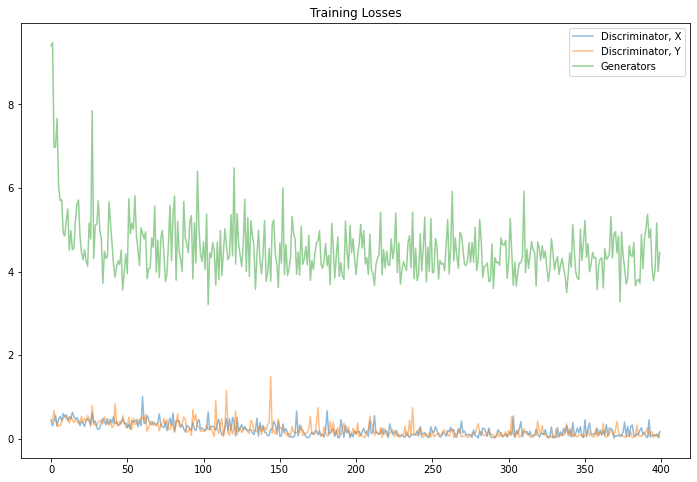

In [24]:
fig, ax = plt.subplots(figsize=(12,8))
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator, X', alpha=0.5)
plt.plot(losses.T[1], label='Discriminator, Y', alpha=0.5)
plt.plot(losses.T[2], label='Generators', alpha=0.5)
plt.title("Training Losses")
plt.legend()

---
## Evaluate the Result!

As you trained this model, you may have chosen to sample and save the results of your generated images after a certain number of training iterations. This gives you a way to see whether or not your Generators are creating *good* fake images. For example, the image below depicts real images in the $Y$ set, and the corresponding generated images during different points in the training process. You can see that the generator starts out creating very noisy, fake images, but begins to converge to better representations as it trains (though, not perfect).

<img src='notebook_images/sample-004000-summer2winter.png' width=50% />

Below, you've been given a helper function for displaying generated samples based on the passed in training iteration.

In [25]:
import matplotlib.image as mpimg

# helper visualization code
def view_samples(iteration, sample_dir='samples_cyclegan'):
    
    # samples are named by iteration
    path_XtoY = os.path.join(sample_dir, 'sample-{:06d}-X-Y.png'.format(iteration))
    path_YtoX = os.path.join(sample_dir, 'sample-{:06d}-Y-X.png'.format(iteration))
    
    # read in those samples
    try: 
        x2y = mpimg.imread(path_XtoY)
        y2x = mpimg.imread(path_YtoX)
    except:
        print('Invalid number of iterations.')
    
    fig, (ax1, ax2) = plt.subplots(figsize=(18,20), nrows=2, ncols=1, sharey=True, sharex=True)
    ax1.imshow(x2y)
    ax1.set_title('X to Y')
    ax2.imshow(y2x)
    ax2.set_title('Y to X')


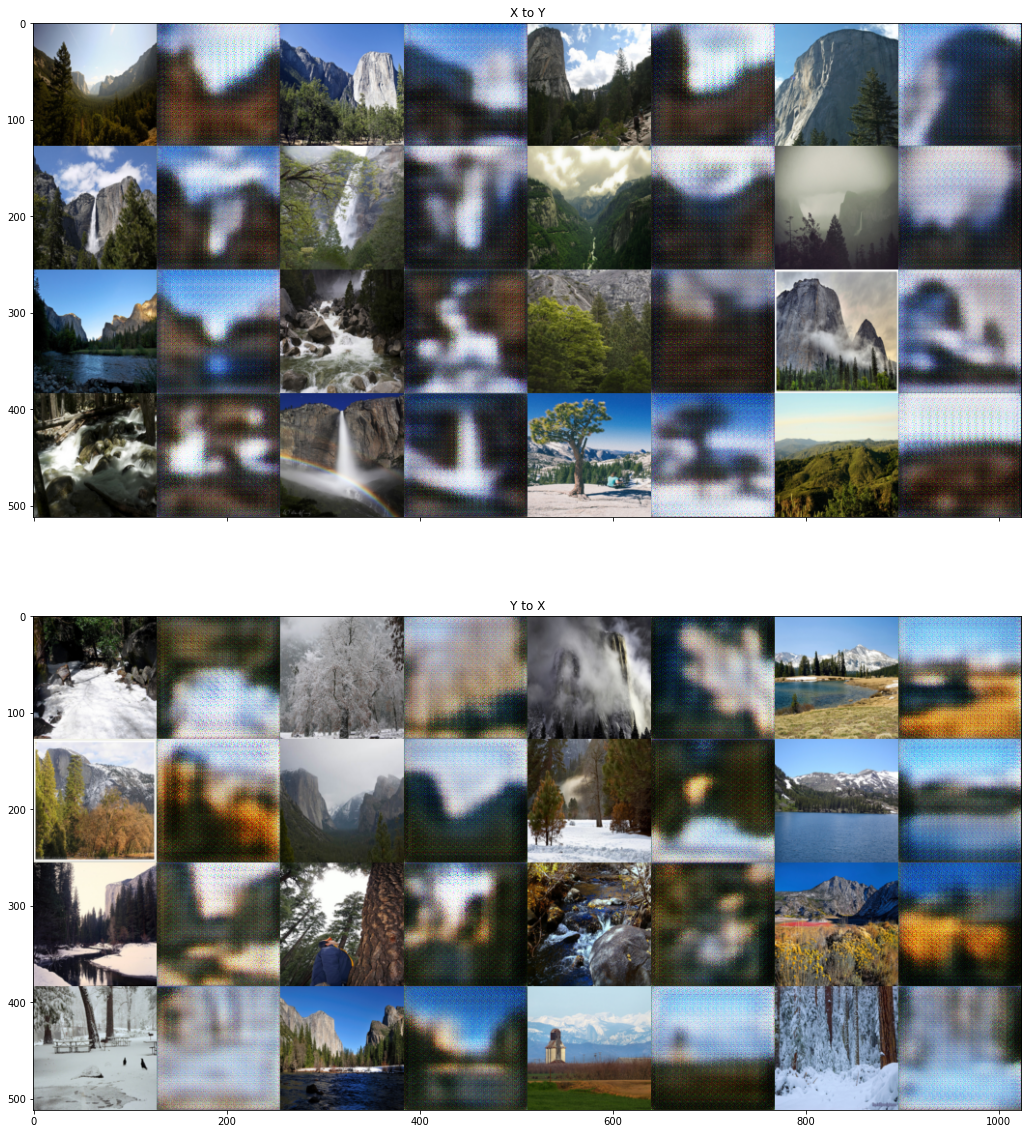

In [26]:
# view samples at iteration 100
view_samples(100, 'samples_cyclegan')

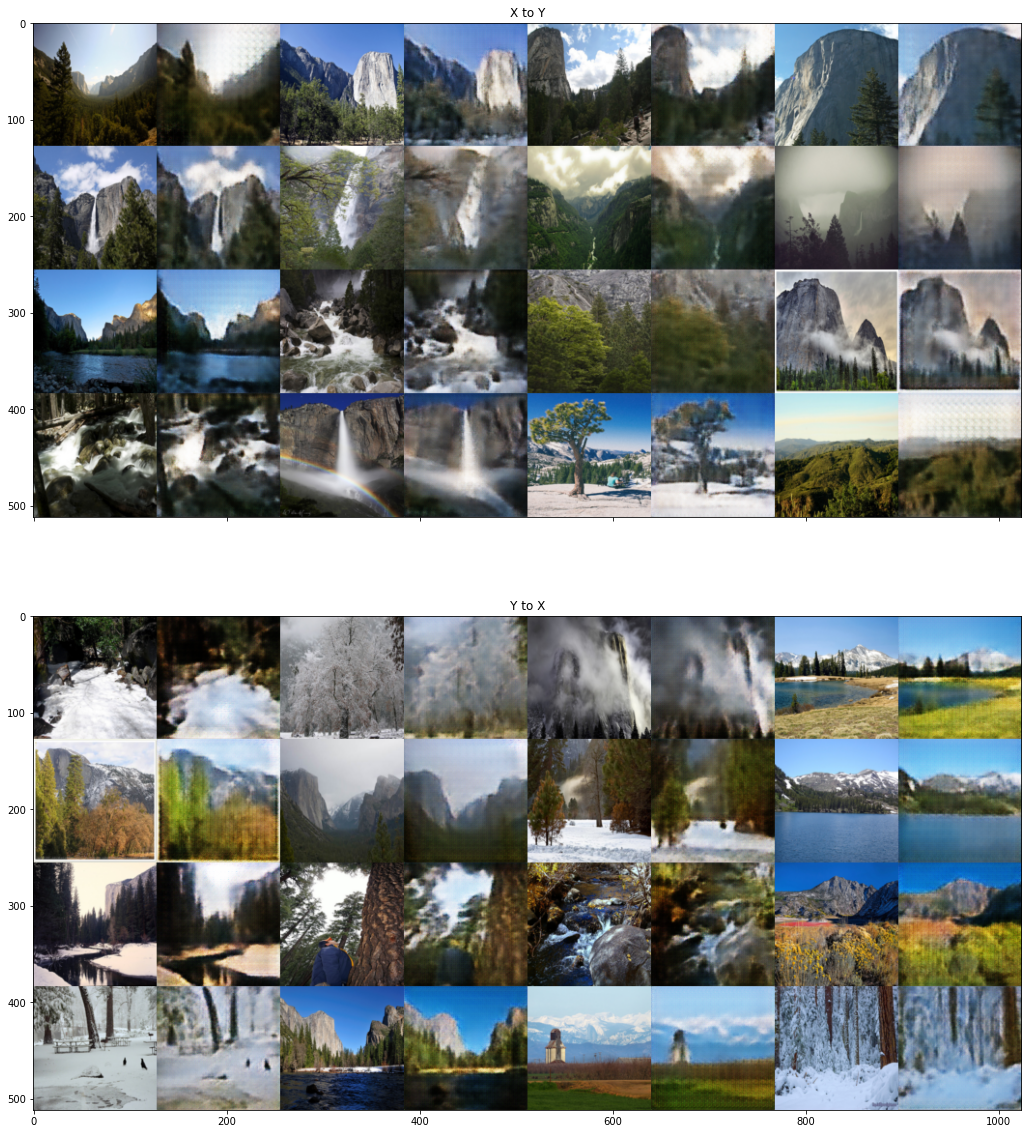

In [27]:
# view samples at iteration 4000
view_samples(4000, 'samples_cyclegan')

---
## Further Challenges and Directions

* One shortcoming of this model is that it produces fairly low-resolution images; this is an ongoing area of research; you can read about a higher-resolution formulation that uses a multi-scale generator model, in [this paper](https://arxiv.org/abs/1711.11585).
* Relatedly, we may want to process these as larger (say 256x256) images at first, to take advantage of high-res data.
* It may help your model to converge faster, if you initialize the weights in your network.
* This model struggles with matching colors exactly. This is because, if $G_{YtoX}$ and $G_{XtoY}$ may change the tint of an image; the cycle consistency loss may not be affected and can still be small. You could choose to introduce a new, color-based loss term that compares $G_{YtoX}(y)$ and $y$, and $G_{XtoY}(x)$ and $x$, but then this becomes a supervised learning approach. 
* This unsupervised approach also struggles with geometric changes, like changing the apparent size of individual object in an image, so it is best suited for stylistic transformations.
* For creating different kinds of models or trying out the Pix2Pix Architecture, [this Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/) which implements CycleGAN *and* Pix2Pix in PyTorch is a great resource.

**Once you are satified with your model, you are ancouraged to test it on a different dataset to see if it can find different types of mappings!**

---

### Different datasets for download

You can download a variety of datasets used in the Pix2Pix and CycleGAN papers, by following instructions in the [associated Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/README.md). You'll just need to make sure that the data directories are named and organized correctly to load in that data.